# Data Preparation:
### Data Preparation it the first step to be performed with the data. This process consists of collecting, cleaning, transforming, and manipulating raw data to make it usable for analysis. 

In [ ]:
import pandas as pd
import os
import plotly.express as px
import matplotlib as plt

import warnings

warnings.filterwarnings("ignore")

# Testing
    This function validates if the files exist

In [2]:
# Function test_file_dublin will check it the files exist in the right path.
def test_file_dublin(path, name_part):
    try:
        files = [file for file in os.listdir(path) if file.startswith(name_part)]
        # Check if any files exist with the given prefix
        assert files, f"No data files found with the prefix: {name_part} in this path: {path}."
    except AssertionError as e:
            print(e)
            return False
    for file in files:
        try:
            assert os.path.exists(path + "/" + file), f"File {file} does not exist."
        except AssertionError as e:
            print(e)
            return False
    return True

# Function test_file_capital will check it the files exist in the right path.
def test_file_capital(path, sufix): 

    try:
        files = [file for file in os.listdir(path) if file.endswith(sufix)]
        # Check if any files exist with the given prefix
        assert files, f"No data files found with the sufix: {sufix} in this path: {path}."
    except AssertionError as e:
            print(e)
            return False
    for file in files:
        try:
            assert os.path.exists(path + "/" + file), f"File {file} does not exist."
        except AssertionError as e:
            print(e)
            return False
    return True


# Dublin Bikes datasets:
These datasets were collected from data.gov.ie and they are under License: Creative Commons Attribution 4.0 (CC BY 4.0).
As more than one file were downloaded, this code will read all files and concatenate into a data frame called dublin_hist.


In [3]:
# Using Test function to verify if files exists:
path = "./"
prefix = 'dublinbike-historical-data-2023'

if test_file_dublin(path,prefix):

    files = [file for file in os.listdir(path) if file.startswith(prefix)] # filter only historical data files

    dublin_hist = pd.DataFrame()

    # for loop will load the file in a dataframe "current_month" and concatenate it to the dataframe "dublin_hist".
    for file in files:
        current_month = pd.read_csv(path+"/"+file)
        dublin_hist = pd.concat([dublin_hist, current_month])

    print(dublin_hist.shape)


(1923492, 11)


### Extracting Station Name and Location for a new dataframe: dublin_bike_stations
From the dataset, the bike stations will be extracted buy removing duplicates stations from all hist also, unicessary columns will be removed

In [4]:
dublin_bike_stations = dublin_hist[['STATION ID','NAME','BIKE_STANDS','STATUS','LATITUDE', 'LONGITUDE']].drop_duplicates(subset=["STATION ID"])

dublin_bike_stations.head()

STATION ID                NAME  BIKE_STANDS STATUS  LATITUDE  LONGITUDE
0           1       CLARENDON ROW           31   OPEN   53.3409   -6.26250
1           2  BLESSINGTON STREET           20   OPEN   53.3568   -6.26814
2           3       BOLTON STREET           20   OPEN   53.3512   -6.26986
3           4        GREEK STREET           20   OPEN   53.3469   -6.27298
4           5    CHARLEMONT PLACE           40   OPEN   53.3307   -6.26018

In [5]:
print('Total of bikes:', dublin_bike_stations['BIKE_STANDS'].sum(),'\nTotal of Stations:' , dublin_bike_stations.shape[0])

Total of bikes: 3647 
Total of Stations: 115


### For proper analysis, only historical data and open station_id will be selected.


In [6]:
# Filtering only OPEN stations and rename columns.
dublin_hist = dublin_hist[dublin_hist['STATUS'] == 'OPEN']

dublin_hist = dublin_hist[['STATION ID', 'TIME', 'BIKE_STANDS', 'AVAILABLE_BIKE_STANDS', 'AVAILABLE_BIKES']]

#rename column AVAILABLE_BIKE_STANDS to BIKES_IN_USE
dublin_hist.rename(columns={'AVAILABLE_BIKE_STANDS': 'BIKES_IN_USE'}, inplace=True)


# Setting the TIME collumn to datetime
dublin_hist['TIME'] = pd.to_datetime(dublin_hist['TIME'])
dublin_hist.head()

STATION ID                TIME  BIKE_STANDS  BIKES_IN_USE  AVAILABLE_BIKES
0           1 2023-01-01 00:00:03           31            31                0
1           2 2023-01-01 00:00:03           20            18                2
2           3 2023-01-01 00:00:03           20             9               11
3           4 2023-01-01 00:00:03           20             8               12
4           5 2023-01-01 00:00:03           40            16               24

### Calculating the number of trips 

To get the number of  trips, its is necessary to create a for loop, to filter the dataframe by STATION ID and compare the number of BIKES_IN_USE from current row, to the previous row (diff),  if the number of BIKES_IN_USE is  bigger the previous row, so its a new trip otherwise not

In [7]:
# create a empty dataframe to receive the cleaned result
bike_usage = pd.DataFrame()

for i in dublin_bike_stations['STATION ID']:
    # filter by STATION ID 
    fitered = dublin_hist[dublin_hist['STATION ID']== i]

    # Sorting by time
    fitered = fitered.sort_values(by=['TIME'], ascending=True)
    
    # creating a new collumn, "TRIPS" and getting the diff of each row
    fitered["TRIPS"] = fitered["BIKES_IN_USE"].diff()
    
    # Concatenat the new bike_usage dataframe with the filtered dataframe (only with trips)
    bike_usage = pd.concat([bike_usage, fitered[fitered['TRIPS']>0]])



bike_usage.head()

STATION ID                TIME  BIKE_STANDS  BIKES_IN_USE  \
1921           1 2023-01-01 08:30:03           31            31   
2938           1 2023-01-01 13:00:02           31            29   
3390           1 2023-01-01 15:00:03           31            29   
3616           1 2023-01-01 16:00:02           31            29   
3842           1 2023-01-01 17:00:03           31            30   

      AVAILABLE_BIKES  TRIPS  
1921                0    1.0  
2938                2    1.0  
3390                2    1.0  
3616                2    1.0  
3842                1    1.0

# Washington D.C. - Capital BikeShare Datasets
These datasets were collected from: https://ride.capitalbikeshare.com/system-data and they are under "Capital Bikeshare Data License Agreement"
As a total de 12 file were downloaded, this code will read all files and concatenate into a data frame called capital_df.



In [8]:
# Using Test function to verify if files exists:
path = "./"
sufix = 'capitalbikeshare-tripdata.csv'

if test_file_capital(path,sufix):

    files = [file for file in os.listdir(path) if file.endswith(sufix) ] # filter only historical data files

    capital_df = pd.DataFrame()

    # for loop will load the file in a dataframe "current_month" and concatenate it to the dataframe "capital_df".
    for file in files:
        current_month = pd.read_csv(path+"/"+file)
        capital_df = pd.concat([capital_df, current_month])

    capital_df.shape

    

### Cleaning Capital_df dataset

In [9]:
# Find out if is there any duplicated row and null value

print('duplicated rides:' ,capital_df['ride_id'].duplicated().sum())
print('Null Values: \n',capital_df.isnull().sum())

duplicated rides: 0
Null Values: 
 ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    354155
start_station_id      354155
end_station_name      376715
end_station_id        376715
start_lat                  0
start_lng                  0
end_lat                 5453
end_lng                 5453
member_casual              0
dtype: int64


Not duplicated rides, but there are some Station_id with null values. Its necessary to fix it


In [10]:
null_rows = capital_df[capital_df.isnull().any(axis=1)]
null_rows.head(2)


ride_id  rideable_type           started_at             ended_at  \
31  25FF612DB868730D  electric_bike  2023-01-24 13:15:25  2023-01-24 13:17:26   
51  0D09AE815D58206D  electric_bike  2023-01-15 20:03:22  2023-01-15 20:09:51   

            start_station_name  start_station_id             end_station_name  \
31  34th St & Wisconsin Ave NW           31226.0                          NaN   
51                         NaN               NaN  Arlington Blvd & N Queen St   

    end_station_id  start_lat  start_lng    end_lat    end_lng member_casual  
31             NaN  38.916483 -77.068194  38.910000 -77.070000        casual  
51         31051.0  38.900000 -77.070000  38.889365 -77.077294        member

For this dataset, each row represents one trip, and threre are other columns differente from dublin Bike, as the purpose is to compare both sistems, this dataset will be engineered to became similar to dublin bikeshare dataset.
As, the purpose of this project is compare the quantity of riders,  the null values will be dropped

In [11]:
# each row represents one trip
capital_df['TRIPS']=1
capital_df = capital_df.dropna(subset=['start_station_id'])
capital_df['start_station_id'] = capital_df['start_station_id'].astype(int)


# Set the right  type format of column
capital_df['started_at'] = pd.to_datetime(capital_df['started_at'])
capital_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3628546 entries, 0 to 358600
Data columns (total 14 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   started_at          datetime64[ns]
 3   ended_at            object        
 4   start_station_name  object        
 5   start_station_id    int32         
 6   end_station_name    object        
 7   end_station_id      float64       
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       object        
 13  TRIPS               int64         
dtypes: datetime64[ns](1), float64(5), int32(1), int64(1), object(6)
memory usage: 401.4+ MB


In [12]:
### Extracting the Bike Station  location
capital_stations = capital_df[['start_station_id','start_station_name','start_lat','start_lng']].drop_duplicates(subset=["start_station_id"])


# rename the columns name
col_names = {'start_station_id': 'station_id', 'start_station_name': 'station_name', 'start_lat': 'lat','start_lng':'long'}
capital_stations.rename(columns=col_names, inplace=True)
capital_stations.head()

station_id                                       station_name        lat  \
0       31904  East Falls Church Metro / Sycamore St & 19th St N  38.885321   
1       32025                         Carroll & Westmoreland Ave  38.975000   
2       31276                                     15th & L St NW  38.903649   
3       32255                             Hartland Rd & Harte Pl  38.878601   
4       32235         Merrifield Cinema & Merrifield Town Center  38.870093   

        long  
0 -77.156427  
1 -77.011210  
2 -77.034918  
3 -77.222808  
4 -77.229970

In [13]:
print('Total of Stations: ' , capital_stations.shape[0])

Total of Stations:  759


# Reviews Datasets for sentment analysis  -  Dublin Bikes and Capital BikeShare
For collection of Dublin Bikes and Capital Bikeshare reviews, a tripadvisor API_KEY was created and stored in an .env file.
Tripeadvisor API allow to request only 5 reviews, which it is not a significant population to perform Machine Learning Sentimental Analysis.
Due this result a Praw library was used to collect comments from Reddit.

**Praw** is an officially supported way to interact with the Reddit API, and Reddit's Terms of Service do allow the use for personal, non-commercial purposes. 

After cleaned, the reviews datasets were saved in csv file to be easier for future loading.

Files:

    dublin_reviews_df.csv
    capital_reviews_df.csv


### Function to Collect reviews from TripAdvisor


In [14]:
from dotenv import load_dotenv
from os import getenv
load_dotenv()
import requests
import json

# Function collect_trip collects reviews from tripadvisor, it receives location_id as a parameter.
# Location_id can be found in tripadvisor website.
def collect_trip (location_id):
    
    # Setting Parameters
    api_key = getenv('API_KEY')   
    
    url = f"https://api.tripadvisor.com/api/partner/2.0/location/{location_id}/reviews"
    headers = { "Content-Type": "application/json", "X-TripAdvisor-API-Key": api_key,}

    # This code makes a GET request, If the status code is 200 (Sucess), then it extracts the 
    #JSON data from the response and converts it into a pandas DataFrame. 
    # If the status code is not 200, then it prints an error message
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        data = response.json()
        return pd.DataFrame( data['data'])
       
    else:
        return "Error",response.status_code

### Collecting reviews from TripAdvisor for Dublin Bikes

In [15]:
#location_id = "6439815"   # Dublin Bikes id in TripAdvisor.
dublin_reviews_df = collect_trip('6439815')

#Select only important features:
dublin_reviews_df = dublin_reviews_df[['title','text']]
dublin_reviews_df.head()

title  \
0  Dublin not a good place for bicycles   
1        Bad service and hidden charges   
2                                  Scam   
3                   No Customer Service   
4                        Terrible site.   

                                                text  
0  1. Dublin is a terrible place to ride a bike, ...  
1  Avoid at all costs! First we had issues signin...  
2  The actual use of the bike while in Dublin was...  
3  The bikes themselves are a bit clunky, but the...  
4  Very bad service. I subscribed for 3 days for ...

### Collecting TripAdvisor reviews for Capital BikeShare

In [16]:
capital_reviews_df = collect_trip('2478701')

#Select only important features:
capital_reviews_df = capital_reviews_df[['title','text']]
capital_reviews_df.head()

title  \
0                             Rideshare, lift E bike   
1  Ridiculous and ancient method of bike sharing ...   
2  ABSOLUTELY TERRIBLE COMPANY--CHARGED ME $250 F...   
3  Convenient and fun but here are some lessons l...   
4                                       Walk instead   

                                                text  
0  My wife and I were recently in Washington DC a...  
1  Attempted to have electronic and or regular bi...  
2  I rented a bike from this company that broke d...  
3  So getting around DC on a bike is great, plent...  
4  Walk, don't bike. Docking stations don't work....

### Function to collect comments from Reddit using Praw Library
Praw was chosen because its the oficial API conector to Reddit.

In [17]:
# First, install praw if its not installed
# !pip install praw

import praw
from datetime import datetime as dt
from dotenv import load_dotenv
from os import getenv

# load .env file
load_dotenv()

# Function collect_reddit: Collects comment from Reddit, it receives the subreddit and the search_query as Paramter, and returns a dataframe
def collect_reddit(subreddit,search_query):
    # Initializing Reddit Api
    reddit = praw.Reddit(
    client_id=getenv("APP_ID"), 
    client_secret=getenv("AP_SECRET"), 
    user_agent=f"pda-jmcloudpro u/{getenv('USERNAME')}", 
    )  
    # Search from subreddit_name
    subreddit = reddit.subreddit(subreddit)
    # Perform a search inside the subreddit
    results = subreddit.search(search_query, limit=500)  
    # Creating Lists to store titles and texts
    titles = []
    texts = []
    # Collect titles and texts
    for submission in results:
        titles.append(submission.title)
        texts.append(submission.selftext)
    # Return a DataFrame with title and comments
    return pd.DataFrame({'title': titles, 'text': texts})
    

### Collecting Reddit Comments for Dublin Bikes and adding to dublin_reviews_df
 

In [18]:
dublin = collect_reddit('Dublin','Dublin Bikes')

#Concatenate TripAdvisor Reviews and Reddit Comments.
dublin_reviews_df = pd.concat([dublin_reviews_df,dublin], ignore_index=True)

dublin_reviews_df.shape

(242, 2)

### Collecting Reddit comments for Capital BikeShare and adding to capital_reviews_df

In [19]:
capital = collect_reddit('washingtondc','Capital Bikeshare')

#Concatenate TripAdvisor Reviews and Reddit Comments.
capital_reviews_df = pd.concat([capital_reviews_df,capital], ignore_index=True)

capital_reviews_df.shape

(202, 2)

# Cleaning reviews datasets:

In [20]:
# dublin_reviews_df - Merging title and text
dublin_reviews_df['text'] = dublin_reviews_df['title'] + ' ' + dublin_reviews_df['text']

# dropping title column
dublin_reviews_df = dublin_reviews_df.drop(columns=['title'])

# removing any special characters, double spaces, tabs etc.
dublin_reviews_df['text'] = dublin_reviews_df['text'].str.replace('[^\w\s\.]','')

#saving as csv
dublin_reviews_df.to_csv('dublin_reviews_df.csv', index = False)


# Dropping na and duplicates
dublin_reviews_df = dublin_reviews_df.dropna()
dublin_reviews_df = dublin_reviews_df.drop_duplicates()

#saving as csv
dublin_reviews_df.to_csv('dublin_reviews_df.csv', index = False)

dublin_reviews_df.head(10)

text
0  Dublin not a good place for bicycles 1. Dublin...
1  Bad service and hidden charges Avoid at all co...
2  Scam The actual use of the bike while in Dubli...
3  No Customer Service The bikes themselves are a...
4  Terrible site. Very bad service. I subscribed ...
5  Dublin bike stations Hey been using Dublin bik...
6  Why is there a complete lack of Dublin bikes s...
7  How are Dublin Bikes these days Havent used th...
8                   Bike theft on Fleet St Dublin 2 
9  Help Dublin bike didnt finish journey Hey. Thi...

In [21]:
# capital_reviews_df - Merging title and text

capital_reviews_df['text'] = capital_reviews_df['title'] + ' ' + capital_reviews_df['text']

capital_reviews_df = capital_reviews_df.drop(columns=['title'])

# removing any special characters, double spaces, tabs etc.
capital_reviews_df['text'] = capital_reviews_df['text'].str.replace('[^\w\s]','')

# Dropping na and duplicates
capital_reviews_df = capital_reviews_df.dropna()
capital_reviews_df = capital_reviews_df.drop_duplicates()


#saving as csv   
capital_reviews_df.to_csv('capital_reviews_df.csv', index = False)

capital_reviews_df.head()

text
0  Rideshare lift E bike My wife and I were recen...
1  Ridiculous and ancient method of bike sharing ...
2  ABSOLUTELY TERRIBLE COMPANYCHARGED ME 250 FOR ...
3  Convenient and fun but here are some lessons l...
4  Walk instead Walk dont bike Docking stations d...

# EDA (Exploratory Data Analysis)  - Understanding the data and patterns

In [22]:
# As the reviews datasets were saved,  its possible to load the dataset, in case of no internet available to collect via API.

dublin_reviews_df = pd.read_csv('dublin_reviews_df.csv')
capital_reviews_df = pd.read_csv('capital_reviews_df.csv')

### Map of the Bike Stations Systems.

Creating maps requires computational resources, and chose the right library  is important. 
**Cartopy and Plotly Express** are two popular options. 

Plotly Express is considered faster due to its vectorized operations and high-performance backend. Therefore, Plotly Express was chosen to create the maps

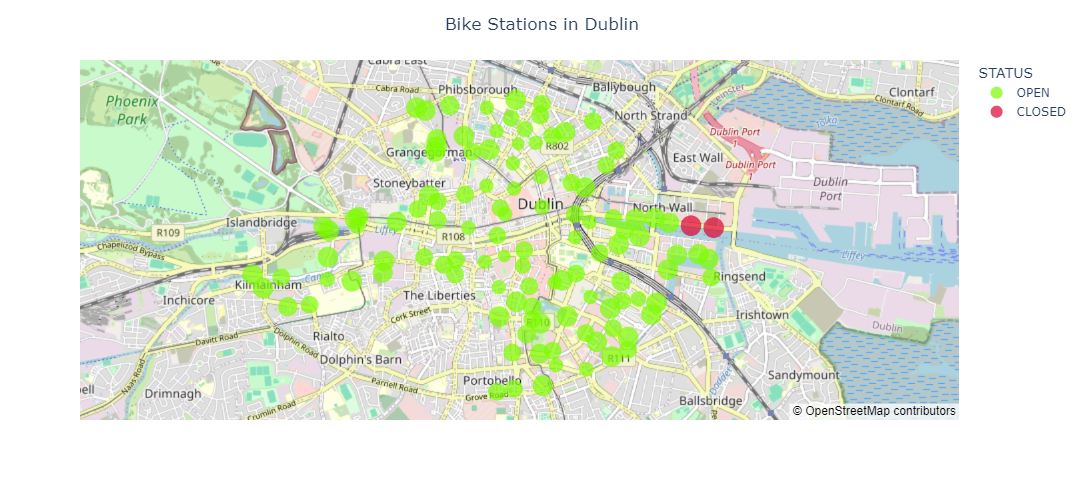

In [23]:
import plotly.express as px
color_mapper = {"OPEN": "#7CFC00", "CLOSED": "#DF0030"}

dublin_map = px.scatter_mapbox(dublin_bike_stations, 
                        lat="LATITUDE",
                        lon="LONGITUDE", 
                        color="STATUS", 
                        size="BIKE_STANDS", 
                        color_discrete_map=color_mapper,
                        size_max=15, 
                        zoom=12, 
                        hover_data=["BIKE_STANDS"],
                        mapbox_style="open-street-map")

# Update layout for larger figure size
dublin_map.update_layout(
    title="Bike Stations in Dublin",
    autosize=False,
    width=800,
    height=500,  
)
dublin_map.update_layout(title_x=0.5)

dublin_map.show()

From the map, it is observed that Dublin bike stations are spread out across the city centre. Also, its observed a few clusters of stations in areas with a high population, e.g., Docklands  and Liberties College, whereas the coverage of bike stations in the suburbs is less dense, there are still a number of stations located in key areas, though. What makes possible for people from the suburbs to cycle to work or school.
Also, the map shows that there are 2 Bikes stations off-line (the red ones)


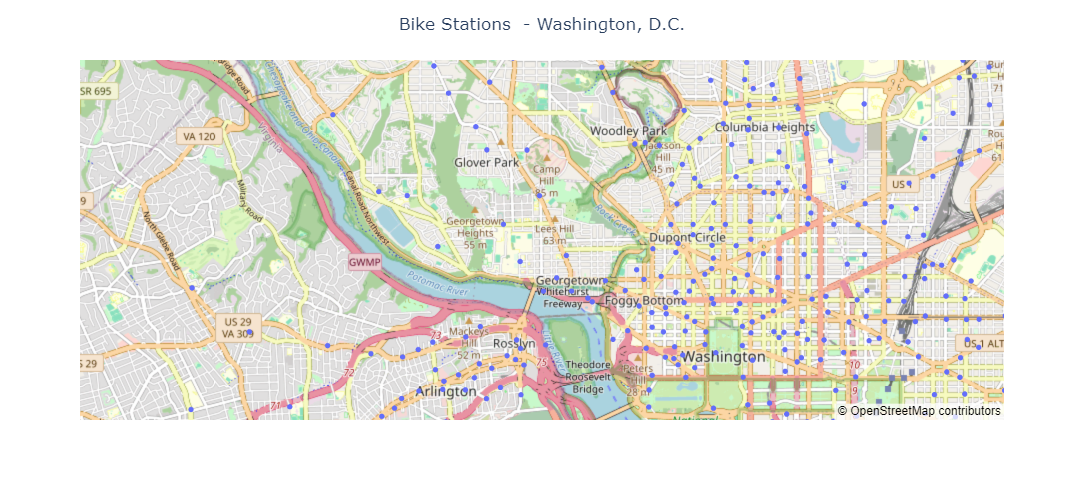

In [24]:
import plotly.express as px


capital_map = px.scatter_mapbox(capital_stations, 
                        lat="lat",
                        lon="long", 
                        size_max=15, 
                        zoom=12, 
                        hover_data=["station_name"],
                        mapbox_style="open-street-map")

# Update layout for larger figure size
capital_map.update_layout(
    title="Bike Stations  - Washington, D.C.",
    autosize=True,
    width=800, 
    height=500,  
)
capital_map.update_layout(title_x=0.5)

capital_map.show()

The map shows that the Capital Bikeshare has a huge Stations Network across the city.
The bike station are located close each other, within a short walk of most destinations. Also, the bike stations in the suburbs is less dense, but there are still a number of stations located in key areas.
    

  ### Top 10 stations with number of trips during the year per Station Name

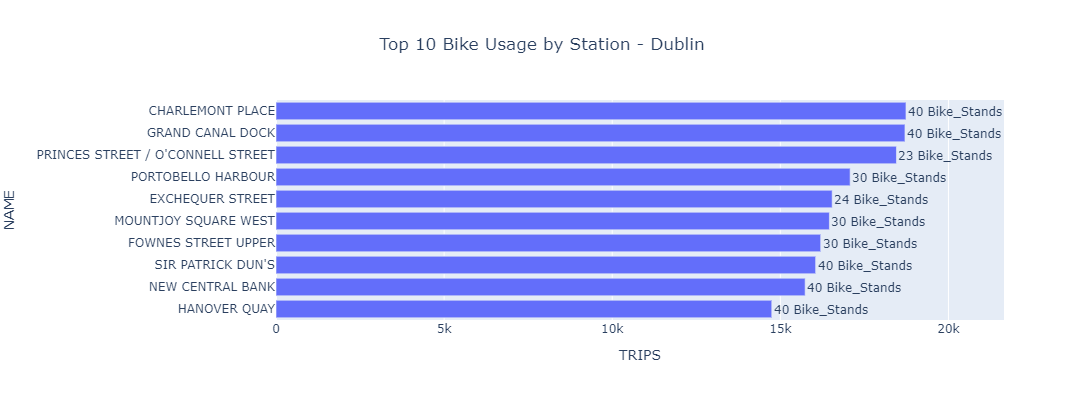

In [25]:
import plotly.express as px
trip_by_station_dublin = bike_usage.groupby(['STATION ID'])['TRIPS'].sum().reset_index()                      
trip_by_station_dublin_join = pd.merge(trip_by_station_dublin, dublin_bike_stations, how='inner', on='STATION ID').sort_values(by = 'TRIPS', ascending = False)
top_stations_dublin = trip_by_station_dublin_join.head(10)

top_10_dublin = px.bar(top_stations_dublin.sort_values(by='TRIPS', ascending = True), 
             x='TRIPS', 
             y='NAME',
             labels=dict(x='TRIPS', y='NAME'),
             title='Top 10 Bike Usage by Station - Dublin',
             hover_data={'BIKE_STANDS': True},
             width=700, 
             height=400, 
             orientation='h')

# Add annotations for BIKE_STANDS inside the bars
for index, row in top_stations_dublin.iterrows():
    top_10_dublin.add_annotation(text=str(row['BIKE_STANDS'])+" Bike_Stands",
                       x=row['TRIPS'],
                       y=row['NAME'],
                       xanchor='left',
                       showarrow=False)
top_10_dublin.update_layout(title_x=0.5)
top_10_dublin.show()


# Insights:
The chart suggests that Dublin bikes is most popular in the city center. The busiest stations are all located in or near the city center, and there is a significant drop-off in usage in the suburbs.
Also, its possible to observe that some stations with fewer bike stands are actually in higher demand than their stand count suggests.

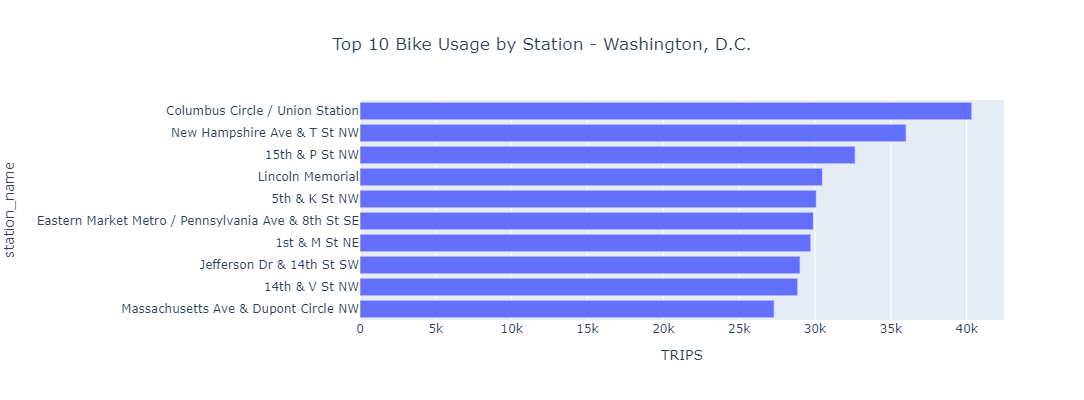

In [26]:
trip_by_station_capital = capital_df.groupby(['start_station_id'])['TRIPS'].sum().reset_index()
trip_by_station_capital_join = pd.merge(trip_by_station_capital,  capital_stations,  how='inner',  right_on='station_id',  left_on='start_station_id').sort_values(by='TRIPS', ascending=False)

top_station_capital = trip_by_station_capital_join.head(10)

top_10_capital = px.bar(top_station_capital.sort_values(by='TRIPS', ascending = True), 
             x='TRIPS', 
             y='station_name',
             labels=dict(x='TRIPS', y='station_name'),
             title='Top 10 Bike Usage by Station - Washington, D.C.',
             width=800, 
             height=400, 
             orientation='h')

top_10_capital.update_layout(title_x=0.5)
top_10_capital.show()

# Insights:
The top 10 stations are located in downtown, residential and commercial areas, that means that Capital Bikeshare is used by people commuting or recreation.
The most frequent bike station, Columbus Circle / Union Station, is located in a transportation hub. This suggests the Capital Bikeshare is used as a solution for people who are commuting.

# Number of trips by weekday and Location
The best approach to perform these chart, is using a dinamic apresentation, and for this purpose, a dashboart using dash and plotly will be created

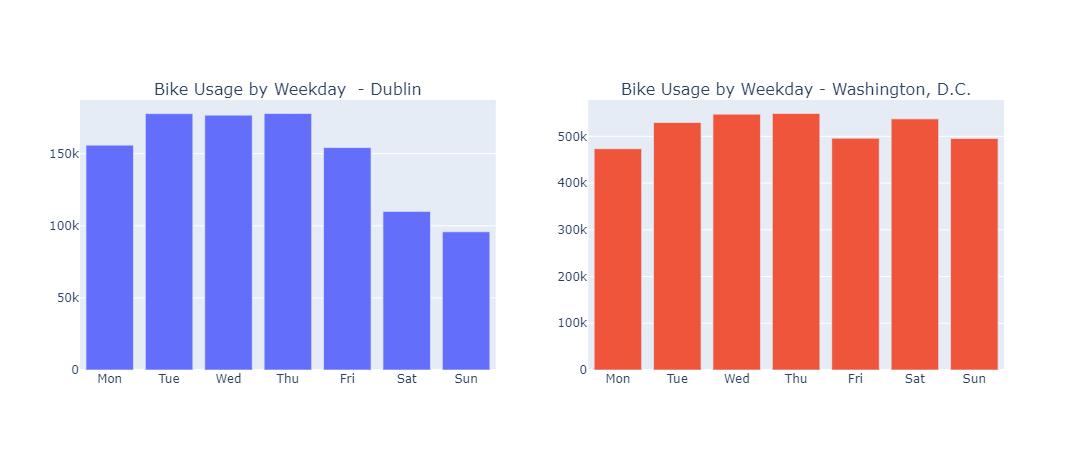

In [27]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go



# Prepare the Plot for Dublin
bike_usage['WEEKDAY'] = bike_usage['TIME'].dt.weekday
dublin_weekady = bike_usage.groupby(['WEEKDAY']).agg( TRIPS=('TRIPS', 'sum')).reset_index().sort_values('WEEKDAY', ascending=True)
# reneame the weedkday using a mpa 
dublin_weekady['WEEKDAY'] = dublin_weekady['WEEKDAY'].map({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'})


# Prepare Weekday dataset
capital_df['WEEKDAY'] = capital_df['started_at'].dt.weekday


capital_weekady = capital_df.groupby(['WEEKDAY']).agg(TRIPS=('TRIPS', 'sum')).reset_index().sort_values('WEEKDAY', ascending=True)


# reneame the weedkday using a mpa 
capital_weekady['WEEKDAY'] = capital_weekady['WEEKDAY'].map({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'})



# Create subplots
bike_usage_weekday = make_subplots(rows=1, cols=2, subplot_titles=('Bike Usage by Weekday  - Dublin', 'Bike Usage by Weekday - Washington, D.C.'))

 
# Add traces for Dublin
plt_dublin_weekady = go.Bar(x=dublin_weekady['WEEKDAY'], y=dublin_weekady['TRIPS'])
bike_usage_weekday.add_trace(plt_dublin_weekady, row=1, col=1)

# Add traces for Washington, D.C.
plt_capital_weekady = go.Bar(x=capital_weekady['WEEKDAY'], y=capital_weekady['TRIPS'], name='Washington, D.C.')
bike_usage_weekday.add_trace(plt_capital_weekady, row=1, col=2)

# Update layout
bike_usage_weekday.update_layout(width=900, height=450, showlegend=False)

# Display the figure
bike_usage_weekday.show()

The chart for Dublin shows that bike usage is highest on Tuesday, Wednesday and Thursday with a considerable decrease at weekend, whereas in Washinbgton D.C the trips are high all days, with a slow decrease on monday.

# Trips by Month and Location

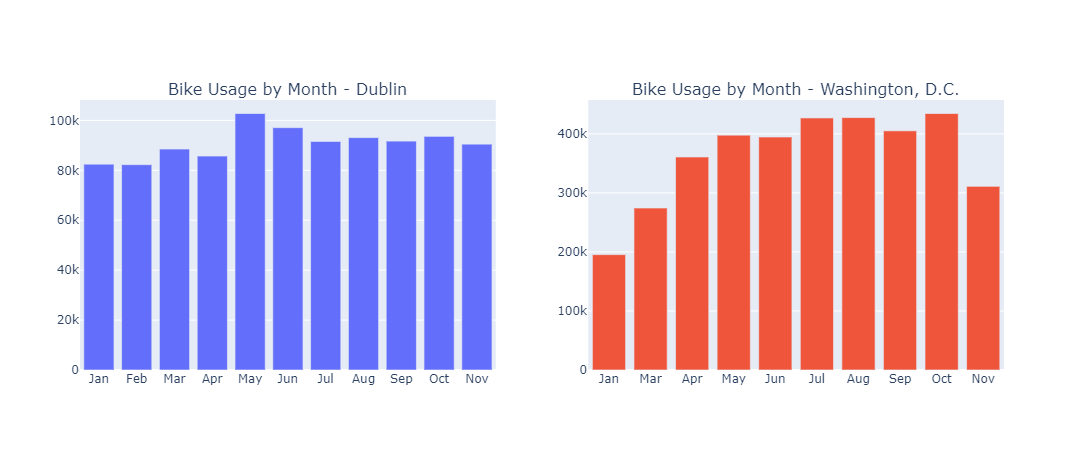

In [28]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Prepare the Plot for Dublin
bike_usage['MONTH'] = bike_usage['TIME'].dt.month

# Filter month from januare to november, to be equal to capital bikeshare period
dublin_month = bike_usage[(bike_usage['MONTH'] <12)].groupby(['MONTH']).agg(TRIPS=('TRIPS', 'sum')).reset_index().sort_values('MONTH', ascending=True)
# reneame the weedkday using a map
dublin_month['MONTH'] = dublin_month['MONTH'].map({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'})



# Prepare Weekday dataset
capital_df['MONTH'] = capital_df['started_at'].dt.month


capital_month = capital_df.groupby(['MONTH']).agg(TRIPS=('TRIPS', 'sum')).reset_index().sort_values('MONTH', ascending=True)


# reneame the weedkday using a mpa 
capital_month['MONTH'] = capital_month['MONTH'].map({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'})

# Create subplots
bike_usage_by_month = make_subplots(rows=1, cols=2, subplot_titles=('Bike Usage by Month - Dublin', 'Bike Usage by Month - Washington, D.C.'))

# Add traces for Dublin
bike_usage_by_month.add_trace(go.Bar(x=dublin_month['MONTH'], y=dublin_month['TRIPS'], name='Dublin'), row=1, col=1)

# Add traces for Washington, D.C.
bike_usage_by_month.add_trace(go.Bar(x=capital_month['MONTH'], y=capital_month['TRIPS'], name='Washington, D.C.'), row=1, col=2)

# Update layout
bike_usage_by_month.update_layout(width=900, height=450, showlegend=False)

# Display the figure
bike_usage_by_month.show()

# Insights
For Dublinbikes, the usage is highest in May and June but for all month, the usage is consistent, between 80k to 100k, where as in Washington, D.C. its possible to observe a big difference between the lowest and the highest month (January and October)

## EDA For sentiment Analisys

### Distribution of reviews lengths

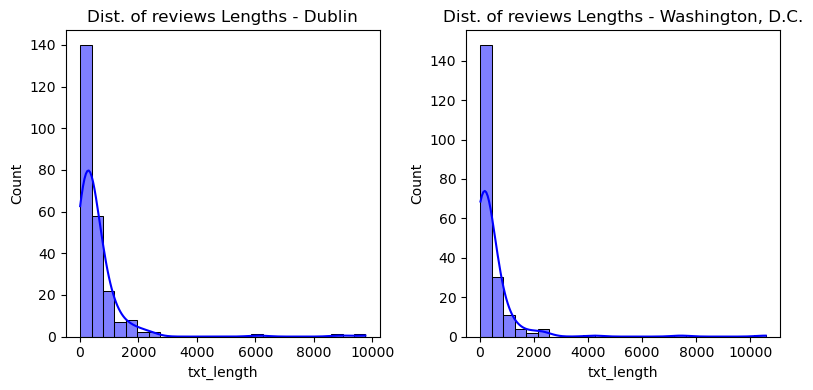

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
dist_rev_len, axes = plt.subplots(1,2, figsize=(8, 4))

# Calculating the length of each review
dublin_reviews_df['txt_length'] = dublin_reviews_df['text'].apply(len)
capital_reviews_df['txt_length'] = capital_reviews_df['text'].apply(len)

# Plotting the distribution of Dublin review lengths
dist_rev_len_dublin = sns.histplot(dublin_reviews_df['txt_length'], ax=axes[0], bins=25, kde=True,color="Blue")
axes[0].set_title(f'Dist. of reviews Lengths - Dublin')

dist_rev_len_capital = sns.histplot(capital_reviews_df['txt_length'], ax=axes[1],bins=25, kde=True,color="Blue")
axes[1].set_title(f'Dist. of reviews Lengths - Washington, D.C.')

# Tighten the layout of the subplots
dist_rev_len.tight_layout()
dist_rev_len.show()

From this Comparison, its possible to observe that there are more loonger reviews for Dublin bikeshare service than for the Washington, D.C. bikeshare service.


# Applying TextBlob and getting Sentiment polarity

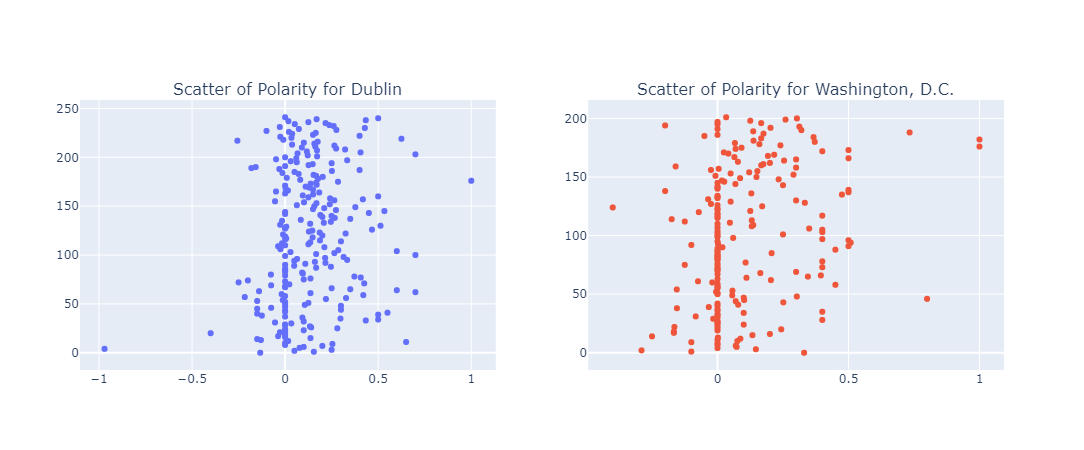

In [30]:
# if not installed, its necessary to install textblob  
# !pip install textblob   # To install uncoment this line

from textblob import TextBlob

# Assuming capital_reviews_df['text'] contains text data for sentiment analysis

# Define a function to calculate sentiment polarity using TextBlob
def calculate_polarity(text):
    return TextBlob(text).sentiment.polarity

# Apply the function to the 'text' column and assign the result to a new column 'Polarity'
dublin_reviews_df['Polarity'] = dublin_reviews_df['text'].apply(calculate_polarity)
capital_reviews_df['Polarity'] = capital_reviews_df['text'].apply(calculate_polarity)


from plotly.subplots import make_subplots
import plotly.graph_objects as go


scatter_polarity = make_subplots(rows=1, cols=2 ,  subplot_titles=('Scatter of Polarity for Dublin', 'Scatter of Polarity for Washington, D.C.'))

# Plotting the distribution of sentiments for Dublin
scatter_polarity.add_trace( go.Scatter(x=dublin_reviews_df['Polarity'], y=dublin_reviews_df.index,mode="markers",name = 'Dublin'), row=1, col=1 )


# Plotting the distribution of sentiments for Capital Bikeshare
scatter_polarity.add_trace(go.Scatter(x=capital_reviews_df['Polarity'], y=capital_reviews_df.index, mode="markers", name = "Washington D.C"),  row=1, col=2)

              
scatter_polarity.update_layout(height=450, width=900,showlegend=False)
scatter_polarity.show()

# Insights from these scatter plot:
Dublin has a higher overall polarity than Washington DC.  which means that comments from Dublin Bikes are more positive or negative on average.
Also, there are more positive sentiment for Dublin whereas, for Washington DC there are more neutral sentiment.


### Labeling the reviews using TextBlob

In [31]:

# This function: textblob_sentiment_analysis takes a review as input and uses TextBlob to analyze its sentiment.

def textblob_sentiment_analysis(review):
    # Analyzing the sentiment of the review
    sentiment = TextBlob(review).sentiment
    # Classifying based on polarity
    if sentiment.polarity > 0.1:
        return 'Positive'
    elif sentiment.polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'
    
# Applying TextBlob sentiment analysis to the reviews
capital_reviews_df['Sentiment'] = capital_reviews_df['text'].apply(textblob_sentiment_analysis)
dublin_reviews_df['Sentiment'] = dublin_reviews_df['text'].apply(textblob_sentiment_analysis)

   
# Displaying the first few rows with the sentiment
display(capital_reviews_df.head(3))
display(dublin_reviews_df.head(3))

text  txt_length  Polarity  \
0  Rideshare lift E bike My wife and I were recen...         509  0.330579   
1  Ridiculous and ancient method of bike sharing ...         493 -0.100000   
2  ABSOLUTELY TERRIBLE COMPANYCHARGED ME 250 FOR ...         602 -0.290000   

  Sentiment  
0  Positive  
1   Neutral  
2  Negative

text  txt_length  Polarity  \
0  Dublin not a good place for bicycles 1. Dublin...         359 -0.133673   
1  Bad service and hidden charges Avoid at all co...         604  0.154444   
2  Scam The actual use of the bike while in Dubli...         231  0.050000   

  Sentiment  
0  Negative  
1  Positive  
2   Neutral

# Comparing the Sentiment in both bike Systems.

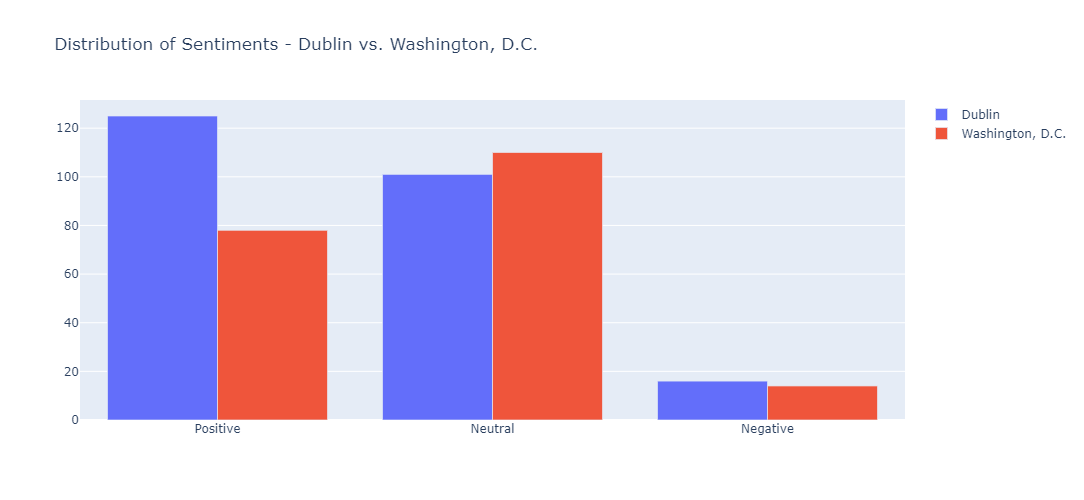

In [32]:

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


# Analyzing the distribution of sentiments

dublin_sentiment_counts = dublin_reviews_df['Sentiment'].value_counts()
capital_sentiment_counts = capital_reviews_df['Sentiment'].value_counts()

# Set the color for each sentiment
sentiment_colors = {
    "Positive": "#00FF00",  # Green for Positive sentiment
    "Neutral": "#0000FF",  # Blue for Neutral sentiment
    "Negative": "#FF0000",  # Red for Negative sentiment
}
# Create a separate layout object



sentiment_dist = make_subplots( )
# Add traces for Dublin
sentiment_dist.add_trace(go.Bar(x=dublin_sentiment_counts.index, y=dublin_sentiment_counts.values, name='Dublin',))
sentiment_dist.add_trace(go.Bar( x=capital_sentiment_counts.index, y=capital_sentiment_counts.values, name='Washington, D.C.',))

# Update layout
sentiment_dist.update_layout(width=800, height=500, showlegend=True, title=("Distribution of Sentiments - Dublin vs. Washington, D.C."))

# Display the figure
sentiment_dist.show()


# Insight:

The graphs show that the sentiment for both: Dublin and Washington D.C is  positive. However, there is a small percentage of negative sentiment for both services.
Also, for Capital Bikeshare, there are more neutral sentiment than positive sentiment.

# Dashboard
For dinamic visualization, a Plotly Dashboard was created.  

This dashboard can be acessed also throught the address:
    http://127.0.0.1:8050



In [33]:
import dash
import dash_bootstrap_components as dbc
import dash_html_components as html
import dash_core_components as dcc
import plotly.express as px
from dash.dependencies import Input, Output
import pandas as pd
import plotly.tools as tls



# Convert matplotlib figure to Plotly figure
plotly_dist_rev_len = tls.mpl_to_plotly(dist_rev_len)


app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])


# styling the sidebar
SIDEBAR_STYLE = {
    "position": "fixed",
    "top": 0,
    "left": 0,
    "bottom": 0,
    "width": "16rem",
    "padding": "2rem 1rem",
    "background-color": "#f8f9fa",
}


# padding for the page content
CONTENT_STYLE = {
    'margin-left': '16rem',
    'margin-right':'2rem',
    'padding': '2rem 1rem',
}

border_style = {
    'width': '400',
    'height': '400',
    'margin': '20px',
    'border-radi    us': '10px',
    'box-shadow': '1 2px 12px rgba(0, 0, 0, 0.2)',
    'border': '2px solid #ccc'
}


menu_style = {
    'textAlign': 'center',
    'font-family': 'Arial',
    'font-weight': 'bold',
    'font-size': '26px',
    'color': '#2196F3',
    'margin': '20px',
    
}



title_style = {
    'textAlign': 'left',
    'font-family': 'Arial',
    'font-weight': 'bold',
    'font-size': '18px',
    'color': '#2196F3',
    'margin': '20px',
    
}
space_style = {
    'height': '200px',
    'border-radius': '10px',
    'box-shadow': '0 2px 12px rgba(0, 0, 0, 0.2)'
}


header_style = {
    'textAlign': 'right',
    'font-family': 'Roboto, sans-serif',
    'font-weight': 'bold',
    'font-size': '14px',
    'color': '#2196F3',
    #'text-transform': 'uppercase',
    'letter-spacing': '0.2rem',
    'background-color': "#f8f9fa",
    'padding': '10px 0'
    }


footer_style = {
    'textAlign': 'center',
    'font-family': 'Roboto, sans-serif',
    'font-size': '8',
    'color': '#2196F3',
    'margin-left': '16rem',

    'letter-spacing': '0.2rem',
    'background-color': "#f8f9fa",
    'padding': '10px 0'    
    }



sidebar = html.Div(
    [
        html.H2("Menu", style=menu_style),
        html.Hr(),

        dbc.Nav(
            [
                dbc.NavLink("Bike Stations", href="/", active="exact"),
                dbc.NavLink("Bike Usage", href="/bike_usage", active="exact"),
                dbc.NavLink("Sentiment Analysis", href="/sentiment", active="exact"),

            ],
            vertical=True,
            pills=True),
        html.Hr(),
    ],
    style=SIDEBAR_STYLE,
)

header = html.Div(
    [
        html.H2(
            "Bike Sharing Analysis - Dublin and Washington D.C.",
            
        ),
        html.Hr(style={'width': '60%', 'border-color': '#ccc'}),
    ], style=header_style,)





content = html.Div(id="page-content", children=[], style=CONTENT_STYLE)



footer = html.Div(
    [
        html.P("Jose Mario Costa  |  www.jmcloudpro.com  |  https://github.com/jmdtanalyst/", style=footer_style)
        
    ], )

app.layout = html.Div([
    dcc.Location(id="url"),
    header,
    sidebar,
    content,
    footer
            

])


@app.callback(
    Output("page-content", "children"),
    [Input("url", "pathname")]
)
def render_page_content(pathname):
    if pathname == "/":
        
        
        return [
                html.H4('Bike Stations Analysis', style=title_style),
                dcc.Graph(id="dublin_map", figure=dublin_map, style=border_style),
                dcc.Graph(id="top_10_dublin", figure=top_10_dublin, style=border_style),
                dcc.Graph(id="capital_map", figure=capital_map, style=border_style),
                dcc.Graph(id="top_10_capital", figure=top_10_capital, style=border_style)
                ]


        
        
    elif pathname == "/bike_usage":
        return [
                html.H4(' Volume of trips by Weekdays', style=title_style),

                dcc.Graph(id="bike_usage_weekday", figure=bike_usage_weekday, style=border_style),
                html.H4(' Volume of trips by Month', style=title_style),

            dcc.Graph(id="bike_usage_by_month", figure=bike_usage_by_month, style=border_style),
                ]
    elif pathname == "/sentiment":
        return [
                html.H1('Sentiment Analysis - TextBlob', style=title_style),
                dcc.Graph(id="scatter_polarity", figure=scatter_polarity, style=border_style),  
                dcc.Graph(id="sentiment_dist2", figure=sentiment_dist, style=border_style), 
                dcc.Graph(id="sentiment_dist", figure=plotly_dist_rev_len, style=border_style),  

                ]
    
    
    # If the user tries to reach a different page, return a 404 message
    return dbc.Jumbotron(
        [
            html.H1("404: Not found", className="text-danger"),
            html.Hr(),
            html.P(f"The pathname {pathname} was not recognised..."),
        ]
    )


if __name__=='__main__':
    app.run_server(debug=True, port=8050)

    

# 2.0 Statistics for Data Analytics
### Descriptive statistics are a set of tools and techniques used to summarize and describe the key features of a dataset.

### Distribution and Density of Dubin bike_usage Dataframe
    plotting the Distribution of the dataset: “bike_usage”, it represents the bike usage in Dublin Bike System.

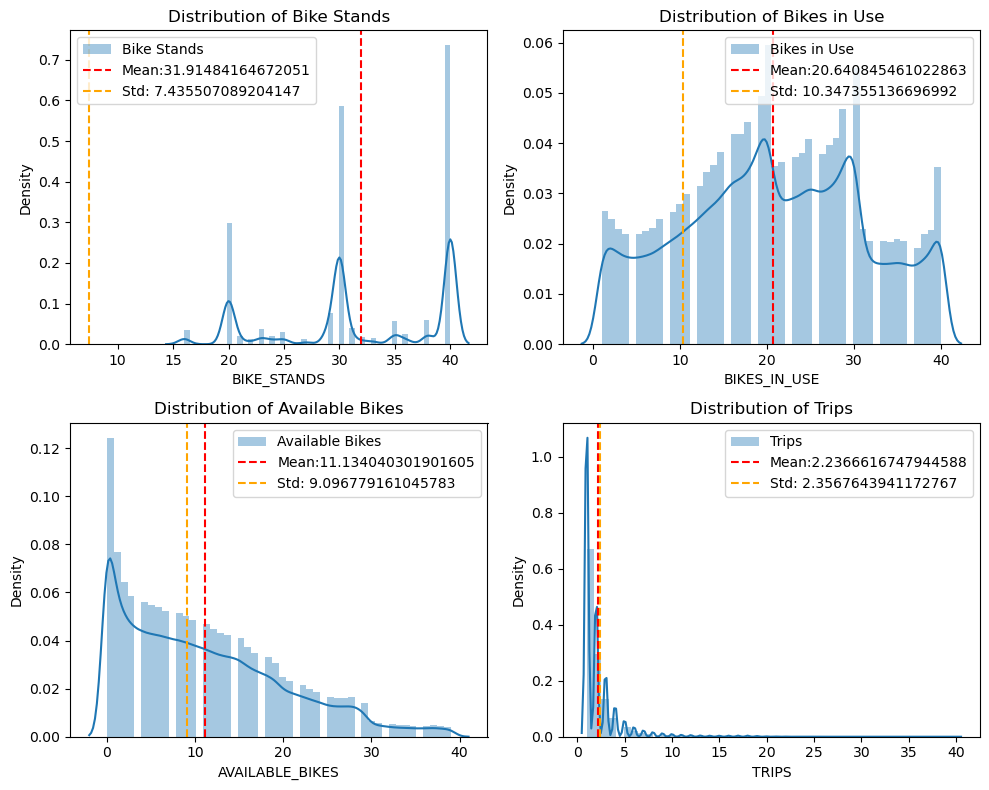

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot the distributions on the subplots

std_dev = bike_usage["BIKE_STANDS"].std()
mean = bike_usage['BIKE_STANDS'].mean()
sns.distplot(bike_usage['BIKE_STANDS'], ax=axes[0, 0], label='Bike Stands')
axes[0, 0].set_title('Distribution of Bike Stands')
axes[0, 0].axvline(bike_usage['BIKE_STANDS'].mean(), color='red', linestyle='--', label=(f'Mean:{mean}'))
axes[0, 0].axvline(bike_usage['BIKE_STANDS'].std(), color='orange', linestyle='--', label= (f'Std: {std_dev}'))
axes[0, 0].legend()



std_dev = bike_usage["BIKES_IN_USE"].std()
mean = bike_usage['BIKES_IN_USE'].mean()                 
sns.distplot(bike_usage['BIKES_IN_USE'], kde=True, ax=axes[0, 1], label='Bikes in Use')
axes[0, 1].set_title('Distribution of Bikes in Use')
axes[0, 1].axvline(bike_usage['BIKES_IN_USE'].mean(), color='red', linestyle='--', label=(f'Mean:{mean}'))
axes[0, 1].axvline(bike_usage['BIKES_IN_USE'].std(), color='orange', linestyle='--', label=(f'Std: {std_dev}'))
axes[0, 1].legend()




std_dev = bike_usage["AVAILABLE_BIKES"].std()
mean = bike_usage['AVAILABLE_BIKES'].mean()
sns.distplot(bike_usage['AVAILABLE_BIKES'], kde=True, ax=axes[1, 0], label='Available Bikes')
axes[1, 0].set_title('Distribution of Available Bikes')
axes[1, 0].axvline(bike_usage['AVAILABLE_BIKES'].mean(), color='red', linestyle='--', label=(f'Mean:{mean}'))
axes[1, 0].axvline(bike_usage['AVAILABLE_BIKES'].std(), color='orange', linestyle='--', label=(f'Std: {std_dev}'))
axes[1, 0].legend()




std_dev = bike_usage["TRIPS"].std()
mean = bike_usage['TRIPS'].mean()
sns.distplot(bike_usage['TRIPS'], kde=True, ax=axes[1, 1], label='Trips')
axes[1, 1].set_title('Distribution of Trips')
axes[1, 1].axvline(bike_usage['TRIPS'].mean(), color='red', linestyle='--', label=(f'Mean:{mean}'))
axes[1, 1].axvline(bike_usage['TRIPS'].std(), color='orange', linestyle='--', label=(f'Std: {std_dev}'))
axes[1, 1].legend()

# Tighten the layout of the subplots
plt.tight_layout()

# Insights
**Distribution of Bike Stands by Density**

The chart shows that the majority of bike stands have a density of between 10 and 25 per unit area. 
However, there is a small number of stations with a significantly higher or lower number of bike stands than the average. 
This suggests that there may be a need to redistribute bike stands to ensure that all stations have a similar number of bike stands available.


**Distribution of Bikes in Use**

From the Distribution of Bikes in Use, with a mean of 20.65 and a standard deviation of 10.33, its possible assume that the majority of bikes in use have a usage of between 10.33 and 30.97. There is a smaller number of bikes that are used more or less than this range.
This suggests that bikes are typically used for a variety of purposes, from short commutes to longer recreational rides..

**Distribution of Available Bikes**

From this chart, its observed that the majority of available bikes have a density of between 10 and 20. Also, there are a smaller number of available bikes with densities below 10 or above 20.
That means, the available bikes are typically concentrated in certain areas, rather than being evenly distributed throughout the area.

**Distribution of Trips**

The distribution of trips is skewed to the right, with a mean of 2.2 and a standard deviation of 2.35. This indicates that there are more times when there are fewer trips than times when there are more trips.

# Distribution and Density of Trips grouped by station on Both Datasets



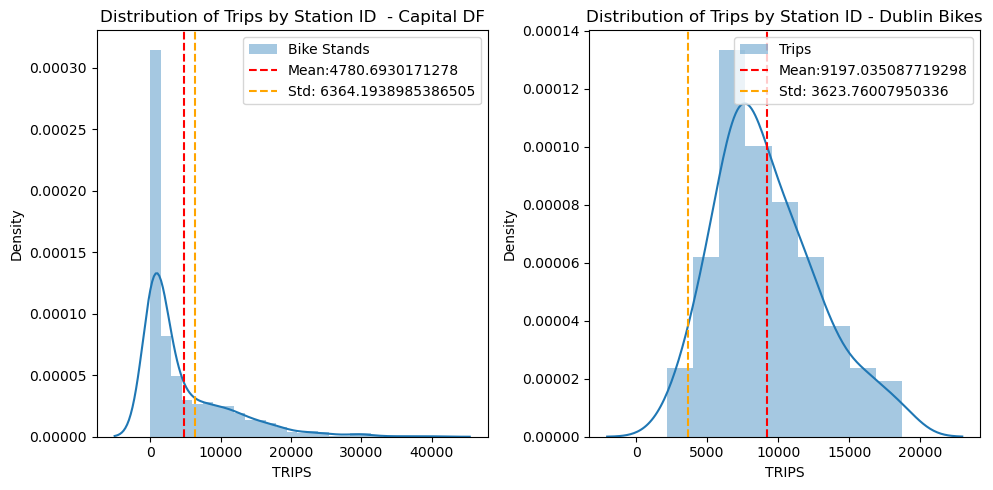

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# grpouping Cpitaol_DF trips by station_id
capital_grp_trips = capital_df.groupby('start_station_id')['TRIPS'].sum().reset_index()

# grpouping Dublin bike_usage df  by station_id
dublin_grp_trips = bike_usage.groupby('STATION ID')['TRIPS'].sum().reset_index()


fig, axes = plt.subplots(1,2, figsize=(10, 5))


# Plot the distributions on the subplots
std_dev = capital_grp_trips["TRIPS"].std()
mean = capital_grp_trips['TRIPS'].mean()               
sns.distplot(capital_grp_trips['TRIPS'], ax=axes[0], label='Bike Stands')
axes[0].set_title('Distribution of Trips by Station ID  - Capital DF')
axes[0].axvline(capital_grp_trips['TRIPS'].mean(), color='red', linestyle='--', label=(f'Mean:{mean}'))
axes[0].axvline(capital_grp_trips['TRIPS'].std(), color='orange', linestyle='--', label= (f'Std: {std_dev}'))
axes[0].legend()


std_dev = dublin_grp_trips["TRIPS"].std()
mean = dublin_grp_trips['TRIPS'].mean()
sns.distplot(dublin_grp_trips['TRIPS'], kde=True, ax=axes[1], label='Trips')
axes[1].set_title('Distribution of Trips by Station ID - Dublin Bikes')
axes[1].axvline(dublin_grp_trips['TRIPS'].mean(), color='red', linestyle='--', label=(f'Mean:{mean}'))
axes[1].axvline(dublin_grp_trips['TRIPS'].std(), color='orange', linestyle='--', label=(f'Std: {std_dev}'))
axes[1].legend()


# Tighten the layout of the subplots
plt.tight_layout()

Its possible to see in both results that the distribution is positively skewed, showing that there are a few stations with a very high number of trips and others stations with a lower number of trips.
Also, the mean number of trips per station is higher for Capital DF (5240) than for Dublin Bikes (9197), this indicates that the average station in Capital DF has more trips than Dublin Station.


# Correlation between features in Dublin bike_share dataframe


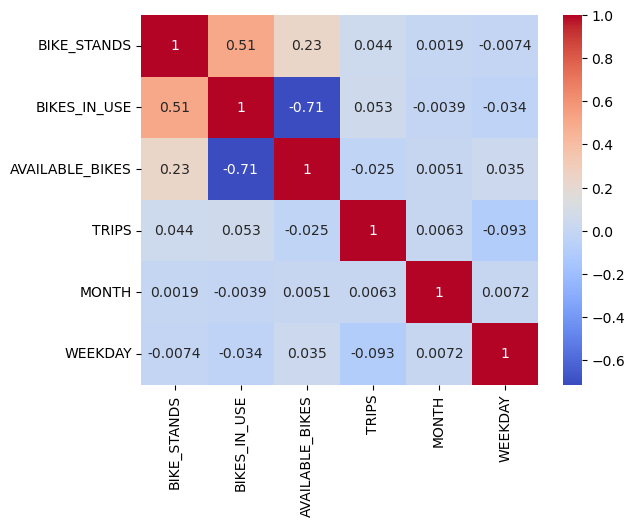

In [36]:
import seaborn as sns
# Correlation between Bike Stands and Bikes in Use
corr = bike_usage[['BIKE_STANDS', 'BIKES_IN_USE', 'AVAILABLE_BIKES', 'TRIPS', 'MONTH', 'WEEKDAY']].corr()

corr_chart = sns.heatmap(corr, annot=True, cmap="coolwarm")

plt.show()



# From this correlation heatmap, its possigle to observe these insights. 

There is a strong negative correlation between BIKE_STANDS and BIKES_IN_USE. This means that as the number of bike stands at a station increases, the number of bikes in use at that station decreases. 
There is a moderate negative correlation between AVAILABLE_BIKES and TRIPS. This means that as the number of available bikes at a station decreases, the number of bike trips starting  from station increases. 
there is a very weak correlation between MONTH and TRIPS. This suggests that the number of bike trips does not vary significantly throughout the year.

# Frequency distribution of WeekDay - Comparing Dublin Dataset to Capital_Df

### Dublin bike_usage dataset

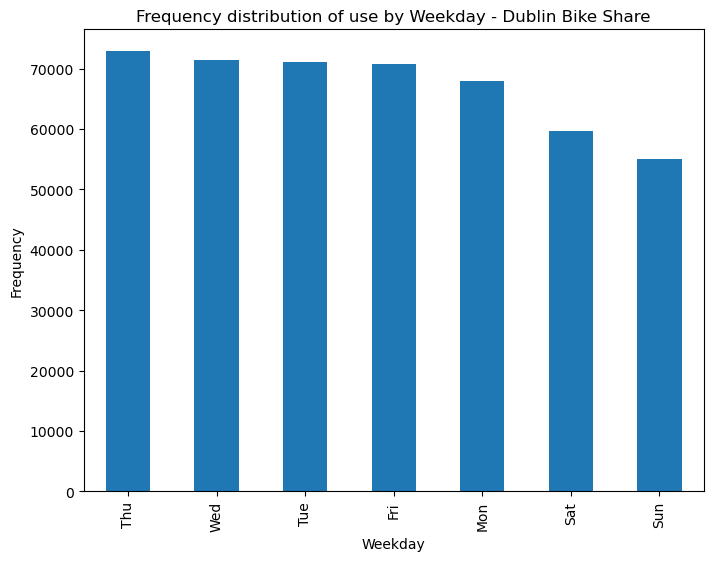

In [37]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt1
plt.figure(figsize=(8, 6))
bike_usage['WEEKDAY'].map({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}).value_counts().plot(kind='bar')
plt.xlabel('Weekday')
plt.ylabel('Frequency')
plt.title('Frequency distribution of use by Weekday - Dublin Bike Share')

plt.show()

### Capital_df Dataset

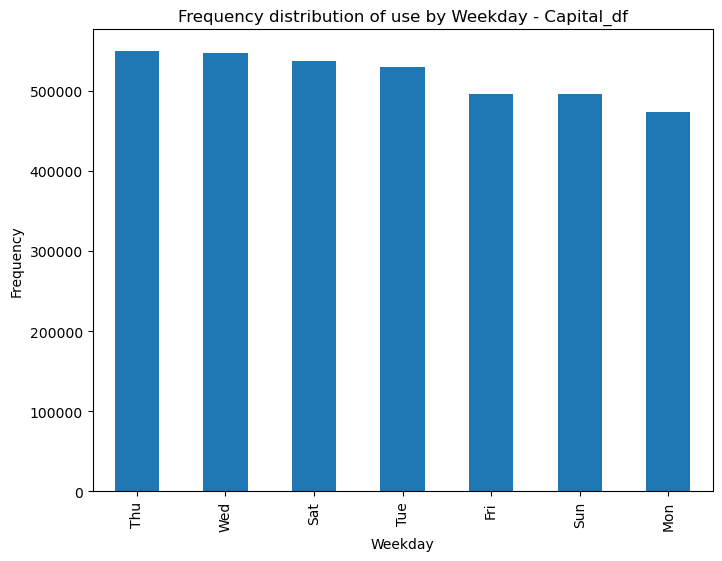

In [38]:

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
capital_df['WEEKDAY'].map({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}).value_counts().plot(kind='bar')
plt.xlabel('Weekday')
plt.ylabel('Frequency')
plt.title('Frequency distribution of use by Weekday - Capital_df')
plt.show()

# Insights from these plots
The bike usage in Dublin peaks on Thursdays, with a dip on Sundays, whereas n Capital DF, Thursday is also the most popular weekday, but Monday is the least popular, highlighting that there is a different behavior in each city.

# Inferential Statistics 
Getting the confidence interval for the population proportion of trips per month.

The population proportion of trips per month is a categorical variable, so we can use the chi-squared test to gain insights into the possible population values.



# Calculating tht confidence interval for the population proportion of trips per month on both datasets

### Dublin bike_usage Dataset


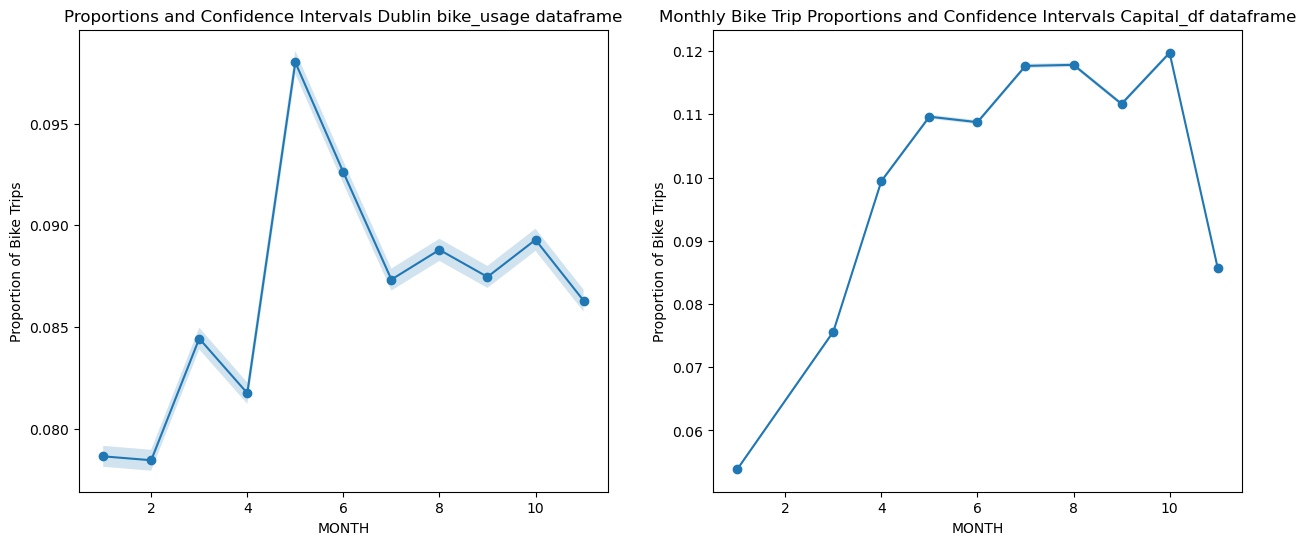

In [39]:
# Import libraries
from statsmodels.stats.proportion import proportion_confint
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 6))


# Calculate Proportion of Bike Trips for Each Month - Dublin Bike share Dataset
# --------------------------------------------------------------
monthly_trips =  bike_usage[bike_usage['MONTH']!=12].groupby('MONTH')['TRIPS'].sum()
total_trips =  bike_usage['TRIPS'].sum()
proportions = monthly_trips / total_trips

# Calculate Confidence Intervals for Proportions
conf_intervals = proportion_confint(count=monthly_trips, nobs=total_trips, alpha=0.05, method='normal')

# Create a DataFrame to store the results
results = pd.DataFrame()
results['TRIPS'] = monthly_trips
results['Proportion'] = proportions.values
results['Lower CI'] =  conf_intervals[0]
results['Upper CI'] =  conf_intervals[1]
results = results.reset_index()

  
# Plot the proportion vs month and overlay the confidence intervals

ax0.plot(results['MONTH'], results['Proportion'], marker='o', linestyle='-')
ax0.fill_between(results['MONTH'], results['Lower CI'], results['Upper CI'], alpha=0.2)

# Set labels and title
ax0.set_xlabel('MONTH')
ax0.set_ylabel('Proportion of Bike Trips')
ax0.set_title('Proportions and Confidence Intervals Dublin bike_usage dataframe')

# -------------------------------------------- End Dublin Bike Share Dataset

# Calculate Proportion of Bike Trips for Each Month - Capital DF Dataset
monthly_trips =  capital_df.groupby('MONTH')['TRIPS'].sum()
total_trips =  capital_df['TRIPS'].sum()
proportions = monthly_trips / total_trips

# Calculate Confidence Intervals for Proportions
conf_intervals = proportion_confint(count=monthly_trips, nobs=total_trips, alpha=0.05, method='normal')

# Create a DataFrame to store the results
results = pd.DataFrame()
results['TRIPS'] = monthly_trips
results['Proportion'] = proportions.values
results['Lower CI'] =  conf_intervals[0]
results['Upper CI'] =  conf_intervals[1]
results = results.reset_index()

  
# Plot the proportion vs month and overlay the confidence intervals

ax1.plot(results['MONTH'], results['Proportion'], marker='o', linestyle='-')
ax1.fill_between(results['MONTH'], results['Lower CI'], results['Upper CI'], alpha=0.2)

# Set labels and title
ax1.set_xlabel('MONTH')
ax1.set_ylabel('Proportion of Bike Trips')
ax1.set_title('Monthly Bike Trip Proportions and Confidence Intervals Capital_df dataframe')


plt.show()

# Insights:

The proportion of bike trips in Dublin varies throughout the year, with the highest proportion of trips occurring in June, July, August.The proportion of bike trips in Dublin has been increasing over time, while the proportion of bike trips in Capidal_DF has remained stable.

### Finding similarities between Dublin (bike_usage) and Washington, D.C. (Capital_Df).
Applying apply parametric and non-parametric inferential statistical techniques(t-test, analysis of variance, Wilcoxon test, chi-squared test, among others).
    
### For this purpose, its necessary become both datasets similar eacah other.


In [40]:
capital_df = capital_df[[ 'start_station_id','started_at',  'WEEKDAY', 'MONTH', 'TRIPS'  ]]
bike_usage = bike_usage[[ 'STATION ID', 'TIME', 'WEEKDAY', 'MONTH', 'TRIPS']  ]
display(capital_df.head(2))
display(bike_usage.head(2))

start_station_id          started_at  WEEKDAY  MONTH  TRIPS
0             31904 2023-01-04 19:34:07        2      1      1
1             32025 2023-01-27 15:26:38        4      1      1

STATION ID                TIME  WEEKDAY  MONTH  TRIPS
1921           1 2023-01-01 08:30:03        6      1    1.0
2938           1 2023-01-01 13:00:02        6      1    1.0

# Sampling
Sampling data is a fundamental practice in statistics and data analysis. When dealing with large populations,

In [41]:
import numpy as np
from scipy.stats import ttest_ind, wilcoxon, chi2_contingency, f_oneway, kruskal

# Randomly sample 20% of bike_usage  dataset
bike_usage_sample = bike_usage.sample(frac=0.05, random_state=42) 
bike_usage_sample.reset_index(drop=True, inplace=True)


# Randomly sample 20% of capital_df dataset
capital_df_sample = capital_df.sample(frac=0.05, random_state=42) 
capital_df_sample.reset_index(drop=True, inplace=True)


# Evaluation of the sample size

Fof validating the sample size, a ECDFs (Empirical Cumulative Distribution Function) was applied in both dataset

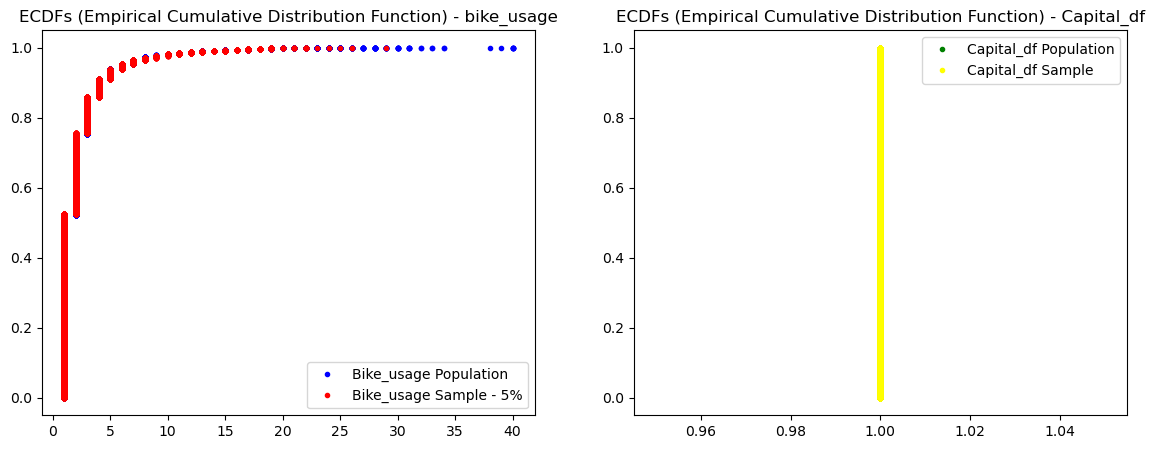

In [42]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(data)+1) / len(data)
    return x, y


# ecdf for Dublin bike_usage
d_x_pop, d_y_pop = ecdf(bike_usage['TRIPS'])
d_x_sample, d_y_sample = ecdf(bike_usage_sample['TRIPS'])


# ecdf for Capital DF
c_x_pop, c_y_pop = ecdf(capital_df['TRIPS'])
c_x_sample, c_y_sample = ecdf(capital_df_sample['TRIPS'])

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Empirical Cumulative Distribution Function) - bike_usage
ax0.plot(d_x_pop, d_y_pop, marker='.', linestyle='none', color='blue', label='Bike_usage Population')
ax0.plot(d_x_sample, d_y_sample, marker='.', linestyle='none', color='red', label='Bike_usage Sample - 5%')
ax0.set_title('ECDFs (Empirical Cumulative Distribution Function) - bike_usage' )
ax0.legend()


# Plot Empirical Cumulative Distribution Function) - Capital_df
ax1.plot(c_x_pop, c_y_pop, marker='.', linestyle='none', color='green', label='Capital_df Population')
ax1.plot(c_x_sample, c_y_sample, marker='.', linestyle='none', color='yellow', label='Capital_df Sample')
ax1.set_title('ECDFs (Empirical Cumulative Distribution Function) - Capital_df' )
ax1.legend()

plt.show()


This sample size of dublin bike_usage doesnt represents the population, it should be increased once the population is much larger than the sample.  so It was applied 20%

In [43]:

import numpy as np
from scipy.stats import ttest_ind, wilcoxon, chi2_contingency, f_oneway, kruskal

# Randomly sample 20% of bike_usage  dataset
bike_usage_sample = bike_usage.sample(frac=0.2, random_state=42) 
bike_usage_sample.reset_index(drop=True, inplace=True)


# Randomly sample 20% of capital_df dataset
capital_df_sample = capital_df.sample(frac=0.2, random_state=42) 
capital_df_sample.reset_index(drop=True, inplace=True)


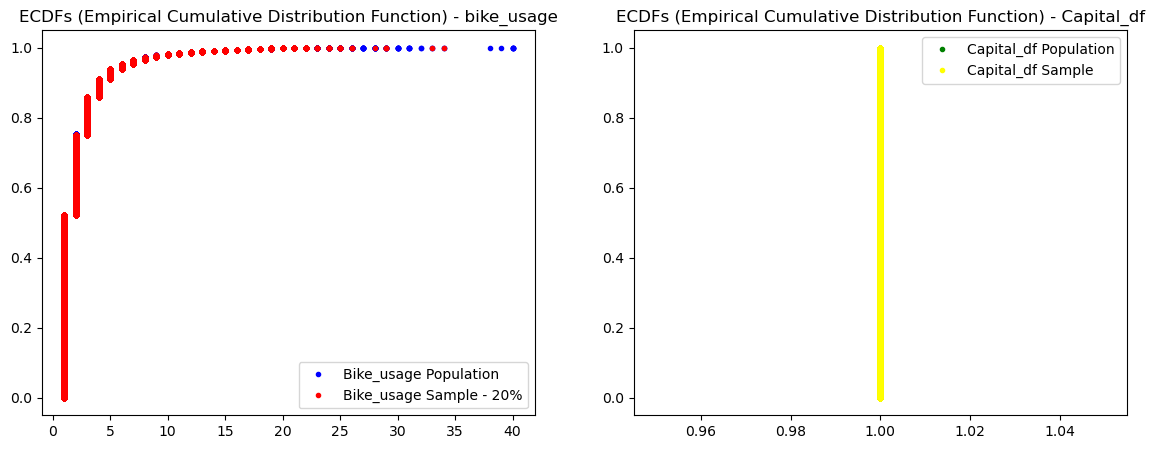

In [44]:

# ECDF -  for Dublin bike_usage
d_x_pop, d_y_pop = ecdf(bike_usage['TRIPS'])
d_x_sample, d_y_sample = ecdf(bike_usage_sample['TRIPS'])


# ecdf for Capital DF
c_x_pop, c_y_pop = ecdf(capital_df['TRIPS'])
c_x_sample, c_y_sample = ecdf(capital_df_sample['TRIPS'])

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Empirical Cumulative Distribution Function) - bike_usage
ax0.plot(d_x_pop, d_y_pop, marker='.', linestyle='none', color='blue', label='Bike_usage Population')
ax0.plot(d_x_sample, d_y_sample, marker='.', linestyle='none', color='red', label='Bike_usage Sample - 20%')
ax0.set_title('ECDFs (Empirical Cumulative Distribution Function) - bike_usage' )
ax0.legend()


# Plot Empirical Cumulative Distribution Function) - Capital_df
ax1.plot(c_x_pop, c_y_pop, marker='.', linestyle='none', color='green', label='Capital_df Population')
ax1.plot(c_x_sample, c_y_sample, marker='.', linestyle='none', color='yellow', label='Capital_df Sample')
ax1.set_title('ECDFs (Empirical Cumulative Distribution Function) - Capital_df' )
ax1.legend()

plt.show()

# With 20% the sample now is in a good size.

# Parametric Tests:

Since the data is about trips at different times and stations, A t-test was applied to compare the means of the trips between Dublin and Washington, D.C.

In [45]:
# Import necessary libraries
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency

# Parametric Test (t-test)
t_stat, p_val = ttest_ind(bike_usage_sample['TRIPS'], capital_df_sample['TRIPS'])
print(f"T-test: t-statistic = {t_stat}, p-value = {p_val}")

# Conclusion
print("\nConclusions:")
if p_val < 0.05:
    print("There is a significant difference between the two datasets.")
else:
    print("There is no significant difference between the two datasets.")


T-test: t-statistic = 448.6097657765749, p-value = 0.0

Conclusions:
There is a significant difference between the two datasets.


In [46]:
# Non-Parametric Test (Wilcoxon)
u_stat, p_val = mannwhitneyu(bike_usage_sample['TRIPS'], capital_df_sample['TRIPS'])
print(f"Wilcoxon test: U-statistic = {u_stat}, p-value = {p_val}")

# Conclusion
print("\nConclusions:")
if p_val < 0.05:
    print("There is a significant difference between the two datasets.")
else:
    print("There is no significant difference between the two datasets.")


Wilcoxon test: U-statistic = 50298527935.5, p-value = 0.0

Conclusions:
There is a significant difference between the two datasets.


In [47]:
# Chi-Squared Test
# Assuming we want to compare the weekday distribution between the two datasets
contingency_table = pd.crosstab(bike_usage_sample['WEEKDAY'], bike_usage_sample['WEEKDAY'])
chi2, p_val, _, _ = chi2_contingency(contingency_table)
print(f"Chi-Squared Test: Chi2 statistic = {chi2}, p-value = {p_val}")

# Conclusion
print("\nConclusions:")
if p_val < 0.05:
    print("There is a significant difference between the two datasets.")
else:
    print("There is no significant difference between the two datasets.")


Chi-Squared Test: Chi2 statistic = 562512.0, p-value = 0.0

Conclusions:
There is a significant difference between the two datasets.


### Hypothesis: Comparing Bike Usage in Dublin and Washington D.C. During Daytime
The hypothesis in question posits that Dublin experiences more bike rides during daytime hours compared to Washington D.C.


In [48]:
# to test this hypotesis, its necessary to filter the dataframe by hour.
# Subset data for daytime (6 am to 6 pm)
bike_usage_sample['HOUR'] = bike_usage_sample['TIME'].dt.hour
dublin_group  = bike_usage_sample.groupby(['HOUR'])['TRIPS'].sum().reset_index()
capital_df_sample['HOUR'] = capital_df_sample['started_at'].dt.hour
capital_group = capital_df_sample.groupby(['HOUR'])['TRIPS'].sum().reset_index()


dublin_sample_daytime = dublin_group[(dublin_group['HOUR'] >= 6) & (dublin_group['HOUR'] < 18)]
capital_sample_daytime= capital_group[(capital_group['HOUR'] >= 6) & (capital_group['HOUR'] < 18)]


# Calculate total trips for each city during daytime
total_trips_dublin = dublin_sample_daytime['TRIPS'].sum()
total_trips_capital = capital_sample_daytime['TRIPS'].sum()

print(f"Total trips in Dublin during daytime: {total_trips_dublin}")
print(f"Total trips in Washington D.C. during daytime: {total_trips_capital}")

Total trips in Dublin during daytime: 154411.0
Total trips in Washington D.C. during daytime: 495674


### Applying T-test to mitigate Type I and Type II Errors on this Hypothesis 

In [49]:
# Hypothesis Testing (comparing means using t-test)
from scipy import stats

t_stat, p_value = stats.ttest_ind(dublin_sample_daytime['TRIPS'], capital_sample_daytime['TRIPS'], equal_var=False)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Reject the null hypothesis: Dublin has more bike usage during daytime than Washington D.C.")
else:
    print("Fail to reject the null hypothesis: No significant difference in bike usage during daytime between Dublin and Washington D.C.")

T-statistic: -6.28647948683623
P-value: 3.8003438486429277e-05
Reject the null hypothesis: Dublin has more bike usage during daytime than Washington D.C.


# Machine Learning for Data Analysis

## Utilizing Time Series to Test and Predict bike usage in Dublin bikeshare dataset.


Filter the dataset to apply in a month (november), Also, its necessary to create a series object with time(datetime) as index, and sum of trips.

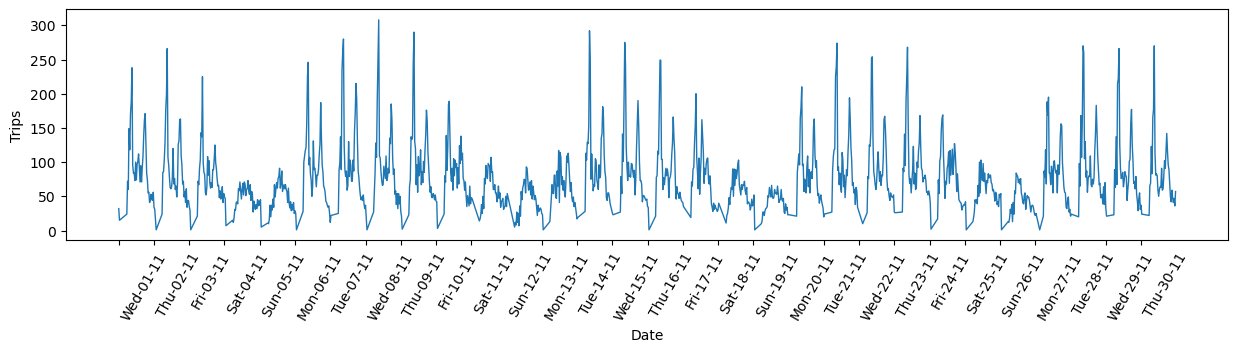

In [50]:
import matplotlib.pyplot as plt

bike_usage_filter = bike_usage[bike_usage['TIME'].dt.month == 11]
bike_series = bike_usage_filter.groupby(['TIME'])['TRIPS'].sum()

# Set the size of the data set
plt.figure(figsize = (15, 3))

# Arrange the data set using date_range() method
xticks = pd.date_range(start = bike_series.index.min(), end = bike_series.index.max(), freq = 'D')

# Set the date format for the plot
#plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation = 60, ha = "left")
plt.xticks(xticks, xticks.strftime("%a-%d-%m"), rotation = 60, ha = "left")

plt.plot(bike_series, linewidth = 1)
plt.xlabel("Date")
plt.ylabel("Trips")
plt.show()

Function to evaluate and plot the prediction, it use the features, target and regressor, also it uses (70%) of data points for training and the rest for testing


In [51]:
from sklearn.metrics import mean_squared_error


# function to evaluate and plot the prediction, it use the features, target and regressor, also it uses (70%) of data points for training and the rest for testing

def eval_on_features(features, target, regressor):
   
    n_train = round(len(features) * 0.7)
    
    # split the given features into a training and a test set
    X_train, X_test = features[:n_train], features[n_train:]
    
    # also split the target array
    y_train, y_test = target[:n_train], target[n_train:]    
    regressor.fit(X_train, y_train)
       
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    
    
    # Plotting the chart
    plt.figure(figsize = (15, 3))
    plt.xticks(range(0, len(X), 40), xticks.strftime("%a %m-%d"), rotation = 60, ha = "left")
    plt.plot(range(n_train), y_train, label = "train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label = "test")
    plt.plot(range(n_train), y_pred_train, '--', label = "prediction train")
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label = "prediction test")
    plt.legend(loc = (1.01, 0))
    plt.title(regressor)
    plt.xlabel("Date")
    plt.ylabel("Trips")
    # End of the chart
    
    
    
    
    # Printting the R^2 and MSE result
    print(f"Model: {regressor}")

    print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test)))
        
    mse_test = mean_squared_error(y_test, y_pred)
    print("Test-set MSE: {:.2f}".format(mse_test))
    
    

# RandomForestRegressor over the entire timestamp

Model: RandomForestRegressor(random_state=0)
Test-set R^2: -0.20
Test-set MSE: 2683.33


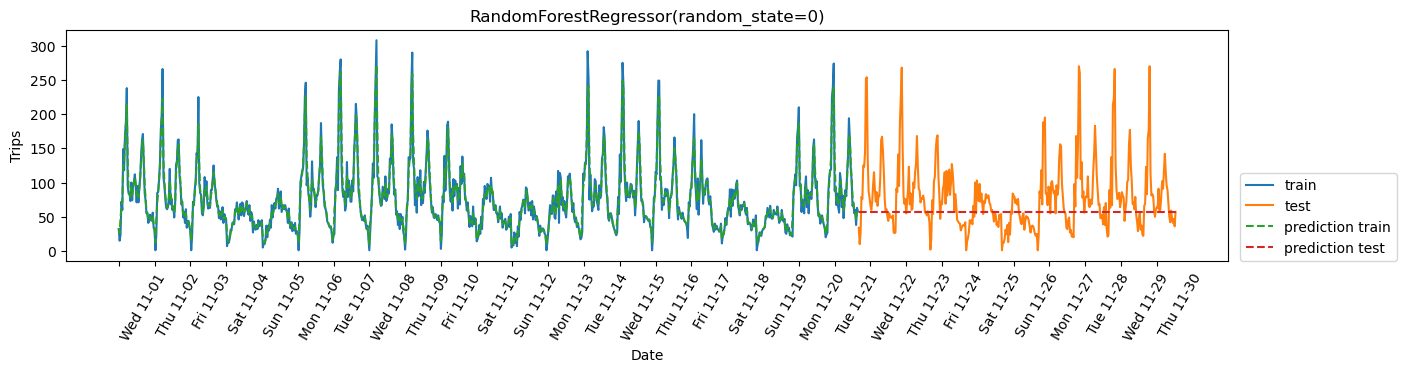

In [52]:

#Extracting the entire timestamp in nanoseconds (POSIX time )
# extract the target values (number of trips)
y = bike_series.values

# convert to POSIX time by dividing by 10**9
X = bike_series.index.astype("int64").values.reshape(-1, 1) // 10**9

from sklearn.ensemble import RandomForestRegressor

# Create an object 'regressor' 
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

# Call the function eval_on_features() to predict and calculate the R^2  and the mean_squared_error
eval_on_features(X, y, regressor)

After Applying this model over the entire timestamp, the result was:
R-squared value of -0.15 shows that its is not a good model, the model performed poorly and it did not explain the variance in the target variable.
A MSE of 2395.29 ondicates that,the difference between the predicted number of trips and the actual number of trips is high, it shows a larger discrepancy between predicted and actual values.

# Aplying RandomForesRegressor over the Hour of the day

Model: RandomForestRegressor(random_state=0)
Test-set R^2: 0.53
Test-set MSE: 1060.65


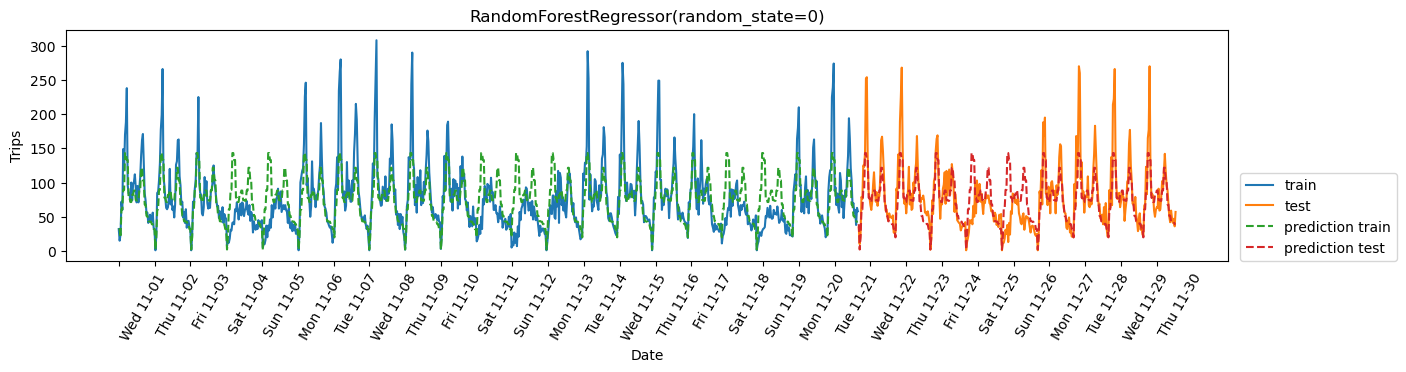

In [53]:
# Store the data hourly in X_hour and make one column using reshape(-1, 1)
X_hour = bike_series.index.hour.values.reshape(-1, 1)

regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

# Call the method eval_on_features() to calculate the R^2  and the mean_squared_erroreval_on_features(X_hour, y, regressor)
eval_on_features(X_hour, y, regressor)

By using the hour of the day as a feature, the RandomForestRegressor model achieved a moderate fit (R^2 of 0.52) and an average prediction error (MSE of 1010.20). which yet is a poor result.

## RandomForestRegressor over the day of the week and the hour of the day

Model: RandomForestRegressor(random_state=0)
Test-set R^2: 0.81
Test-set MSE: 433.23


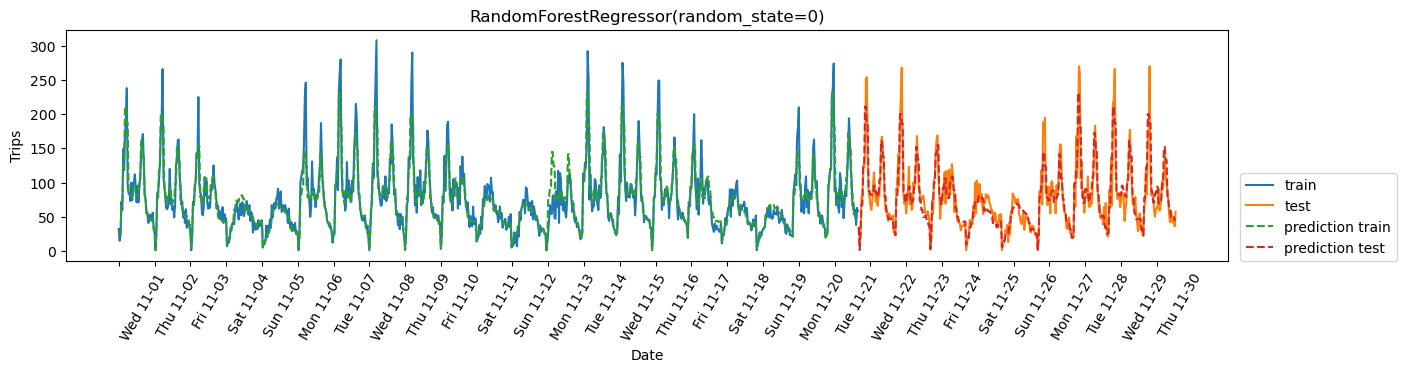

In [54]:
import numpy as np
# Store the hourly data weekly in X_hour_week and make one column using reshape(-1, 1)
X_day_hour_week = np.hstack([bike_series.index.dayofweek.values.reshape(-1, 1), bike_series.index.hour.values.reshape(-1, 1)])

regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

# Call the method eval_on_features() to calculate the R^2  and the mean_squared_erroreval_on_features(X_hour, y, regressor)
eval_on_features(X_day_hour_week, y, regressor)

By applying both features, day of the week and hour, model achieved better result, a strong fit (0.80) and a reduced the MSE (408.83).
What means that taking both factores, the model can provide a better prediction of bike trips

### Tuning RandomForestRegressor model applying hyperparameter 
    

In [55]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

y = bike_series.values
X = bike_series.index.astype("int64").values.reshape(-1, 1) // 10**9

# Define Parameter Grid for GridSearchCV:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create GridSearchCV Object:
grid_search = GridSearchCV(RandomForestRegressor(random_state=0), param_grid, cv=3, n_jobs=-1, verbose=2)

grid_search.fit(X, y)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X)

# Calculate metrics
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"R^2 Score: {r2}")
print(f"Mean Squared Error: {mse}")



Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 150}
R^2 Score: 0.6485050484758772
Mean Squared Error: 801.5832897345575


### Applying RandomForestRegressor after Hyperparameter tuning

Model: RandomForestRegressor(max_depth=10, min_samples_leaf=4, n_estimators=150,
                      random_state=0)
Test-set R^2: 0.81
Test-set MSE: 425.70


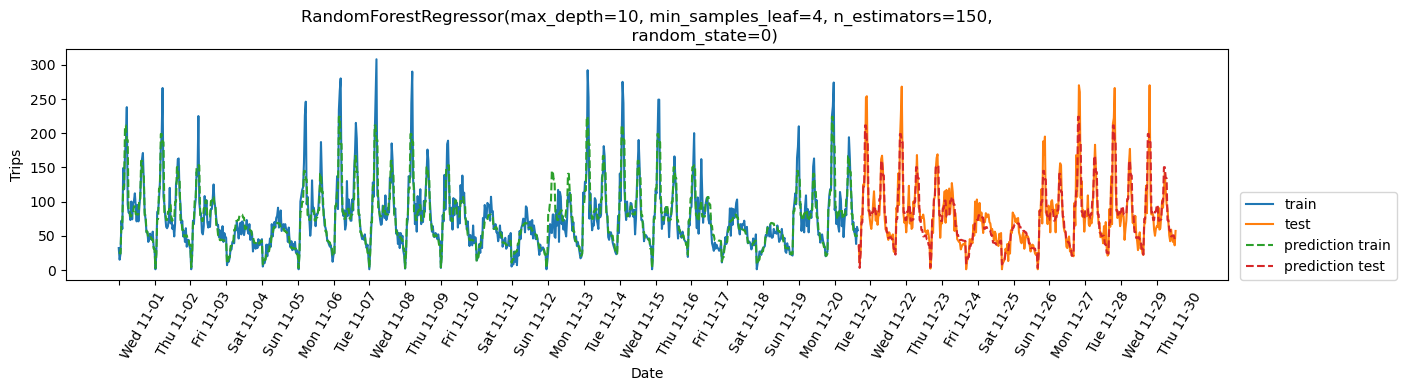

In [56]:

# Based on the result of GridSearchCV Tunning, the best hyperparameters will be applied
regressor = RandomForestRegressor(n_estimators=150, 
                                       max_depth=10, 
                                       min_samples_leaf=4, 
                                       min_samples_split=2, 
                                       random_state=0)
    # Store the hourly data weekly in X_hour_week and make one column using reshape(-1, 1)
X_day_hour_week = np.hstack([bike_series.index.dayofweek.values.reshape(-1, 1), bike_series.index.hour.values.reshape(-1, 1)])


# Call the method eval_on_features() to calculate the R^2  and the mean_squared_erroreval_on_features(X_hour, y, regressor)
eval_on_features(X_day_hour_week, y, regressor)
    

# Linear Regression over the day of the week and the hour of the day

Model: LinearRegression()
Test-set R^2: 0.08
Test-set MSE: 2071.39


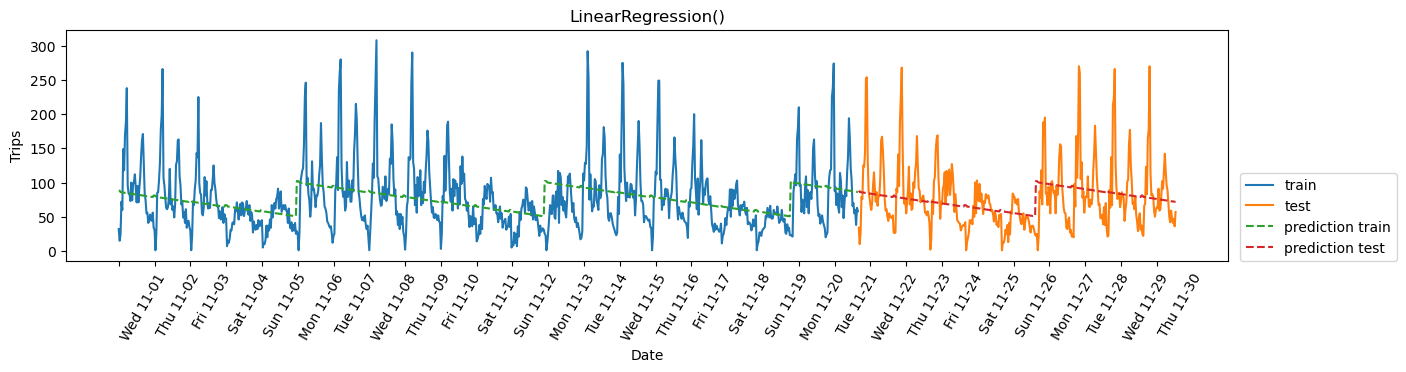

In [57]:
# import LinearRegression library from sklearn
from sklearn.linear_model import LinearRegression

# Call the method eval_on_features() to calculate the R^2  and the mean_squared_erroreval_on_features(X_hour, y, regressor)
eval_on_features(X_day_hour_week, y, LinearRegression())

By applying linear regression, the model achieved a bad result, R^2 value of 0.08 and a high prediction error MSE of 2071.39.

### Converting categorical data into numerical representation, applying One-hot encoding.
    

In [58]:
# import OneHotEncoder from sklearn
from sklearn.preprocessing import OneHotEncoder

# Declare an object (enc) by calling a method OneHotEncoder()
enc = OneHotEncoder()

# Create an array by calling a fit() method
X_day_hour_week_onehot = enc.fit_transform(X_day_hour_week).toarray()



# Using a combination of polynomial features and ridge regression

Model: Ridge()
Test-set R^2: 0.79
Test-set MSE: 463.64


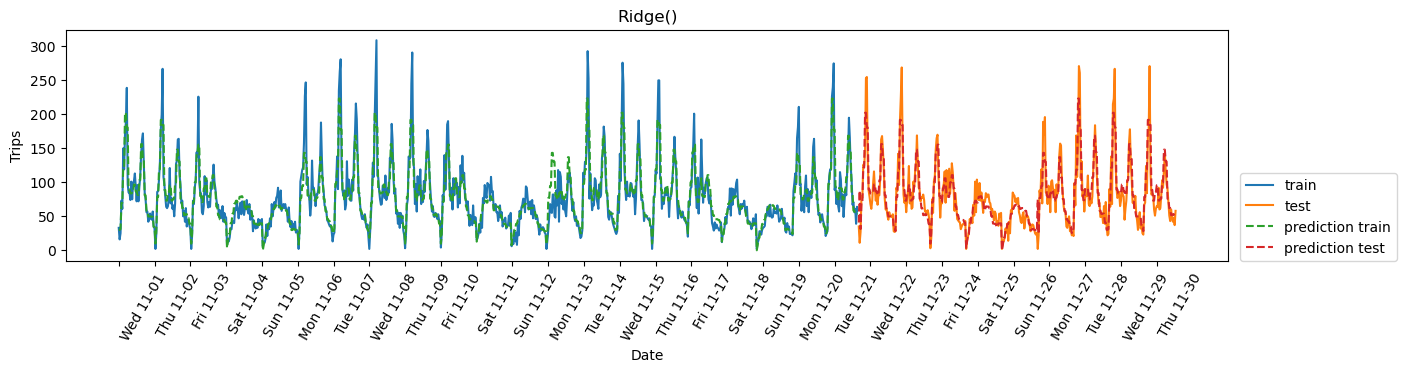

In [59]:
# import polynomial library from sklearn
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

# Create and initialise an object named as PolynomialFeatures()
poly_transformer = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False)

# Call fit() method to train the model
X_day_hour_week_onehot_poly = poly_transformer.fit_transform(X_day_hour_week_onehot)

# Initialise an object by calling a method Ridge()
lr = Ridge()

# Call a method eval_on_features() to evaluate R^2 and plot 
eval_on_features(X_day_hour_week_onehot_poly, y, lr)

By transforming the categorical data into numerical using one-hot encoding and incorporating polynomial features in combination with Ridge regression, the model have improved. With R^2 of 0.79 and  MSE value of 463.64. this model performed similar RandomForesRegressor over the day of the week and the hour of the day.

# Deploying the model for future use

In [60]:
import joblib

# Save the trained model
joblib.dump(regressor, 'random_forest_regressor.pkl')

['random_forest_regressor.pkl']

In [61]:
# Load the saved model
loaded_regressor = joblib.load('random_forest_regressor.pkl')

# Conclusion:
    
From these 3 models, its possible to observe that RandomForestRegressor model performed better than other two. indeed, After applying hyperparameter tuning using GridSearchCV, the result was even better, The Ridge regression, Despite its potential with one-hot encoding and polynomial features, performed similar, but slightly behind the RandomForestRegressor, whereas the LinearRegression model performed worse.



# Sentimental Analysis

For sentiment analysis, TextBlob is a commonly used library, (as was applied on Data Visualization Session), TextBlob calculates polarity to determine sentiment. However, its accuracy is considered moderate. For more precise accuracy, there are machine learning techniques designed specifically for sentiment analysis. 
For example:"

**VADER (Valence Aware Dictionary and Sentiment Reasoner):** 

    Is specifically designed for analyzing sentiments in social media text and has been trained on such data.
    VADER uses a combination of a sentiment lexicon (a predefined list of words with associated sentiment scores) and a set of grammatical rules to determine the sentiment of a text.
    
    * a positive sentiment, compound ≥ 0.05.
    * a negative sentiment, compound ≤ -0.05.
    * a neutral sentiment, the compound is between -0.05, 0.05


**Bag of Words (BoW) vectorization approach:** 

    It is another technique commonly used in sentiment analysis and text classification tasks.

# Applaying VADER on Bikeshare services

In [62]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer


import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings


In [63]:
# if not installed, its necessary to install vaderSentiment
#!pip install vaderSentiment

# Download the lexicon
nltk.download("vader_lexicon") 

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\JoseMariodaCruzCosta\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Understanding VADER

In [64]:
# Create an instance of SentimentIntensityAnalyzer
sent_analyzer = SentimentIntensityAnalyzer()

# Example
sentence = "VADER is the best tool for sent/ment analysis!"
result = sent_analyzer.polarity_scores(sentence)

result

{'neg': 0.0, 'neu': 0.609, 'pos': 0.391, 'compound': 0.6696}

The result shows that the sentence does not have any negative information (neg=0). It has some neutral and positive tones (neu=0.609 and pos=0.391). However, the overall sentiment is positive, because compound > 0.05


In [65]:
#Loading Reviews
dublin_reviews_df = pd.read_csv('dublin_reviews_df.csv')
capital_reviews_df = pd.read_csv('capital_reviews_df.csv')
capital_reviews_df['text'] = capital_reviews_df['text'].str.lower()
dublin_reviews_df['text'] = dublin_reviews_df['text'].str.lower()


# Create an instance of SentimentIntensityAnalyzer
sent_analyzer = SentimentIntensityAnalyzer()

# function label_output labels the output based on compound
def label_output(output_dict):
  
  polarity = "neutral"

  if(output_dict['compound'] >= 0.05):
    polarity = "positive"

  elif(output_dict['compound'] <= -0.05):
    polarity = "negative"

  return polarity


# Function sentment analyzes the text and returns the compound
def sentiment(text):
  
  output_dict =  sent_analyzer.polarity_scores(text)
  return label_output(output_dict)



In [66]:
# Applygint in both datasets
dublin_reviews_df["vader_prediction"] = dublin_reviews_df["text"].apply(sentiment)
capital_reviews_df["vader_prediction"] = capital_reviews_df["text"].apply(sentiment)
display(dublin_reviews_df.head(2))
display(capital_reviews_df.head(2))


text vader_prediction
0  dublin not a good place for bicycles 1. dublin...         positive
1  bad service and hidden charges avoid at all co...         negative

text vader_prediction
0  rideshare lift e bike my wife and i were recen...         positive
1  ridiculous and ancient method of bike sharing ...         negative

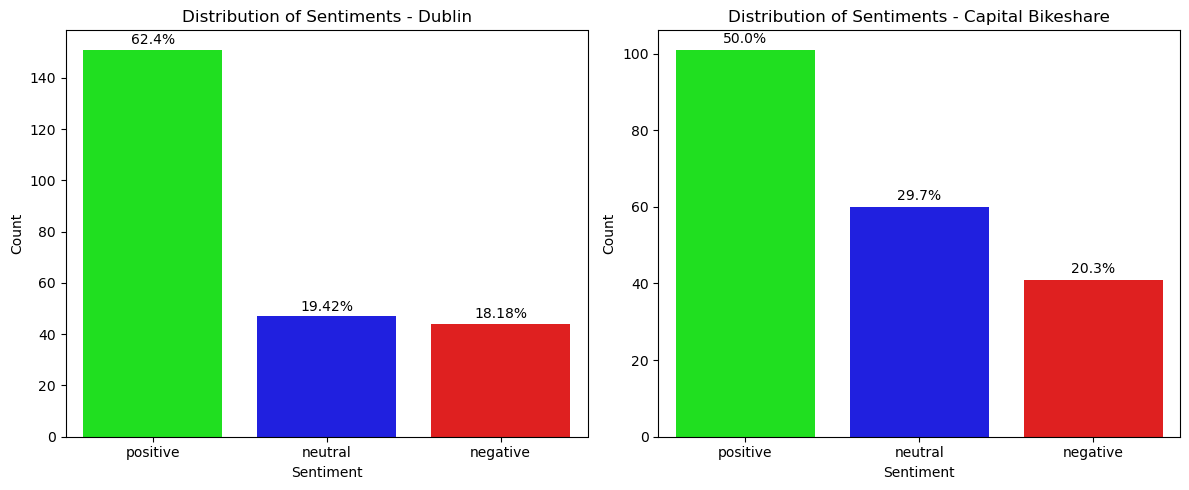

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# Analyzing the distribution of sentiments
dublin_vader = dublin_reviews_df['vader_prediction'].value_counts()
capital_vader = capital_reviews_df['vader_prediction'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Defining custom color palettes
colors = {
    'negative': "#FF0000",  # Red for Negative sentiment
    'neutral': "#0000FF",   # Blue for Neutral sentiment
    'positive': "#00FF00"  # Green for Positive sentiment
}

# Plotting the distribution of sentiments for Dublin
sent_dub = sns.barplot(x=dublin_vader.index, y=dublin_vader.values, ax=axes[0], palette=colors)

# Calculating percentages of each sentiment
total_values = sum(dublin_vader.values)
for i, v in enumerate(dublin_vader.values):
    percentage = round(v / total_values * 100, 2)
    axes[0].text(i, v + 1, f"{percentage}%", ha='center', va='bottom', color='black')

axes[0].set_title('Distribution of Sentiments - Dublin')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Count')

# Plotting the distribution of sentiments for Capital Bikeshare
sns.barplot(x=capital_vader.index, y=capital_vader.values, ax=axes[1], palette=colors)

# Calculating percentages of each sentiment
total_values = sum(capital_vader.values)
for i, v in enumerate(capital_vader.values):
    percentage = round(v / total_values * 100, 2)
    axes[1].text(i, v + 1, f"{percentage}%", ha='center', va='bottom', color='black')

axes[1].set_title('Distribution of Sentiments - Capital Bikeshare')
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


The model seems to be doing a good job because it is much better than a random guess (accuracy = 0.5)! The same observation can be made from the f1-scores of each polarity. Before diving into building machine learning models, it might be better to take VADER as your baseline model for such a task.

### Creating Models applying Bag of Words (BoW) and TF-IDF Vectorization"

In [68]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer



# Download stopwords if not already downloaded
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JoseMariodaCruzCosta\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package stopwords is already up-to-date!


True

In [69]:
# Function sentiment_analysis  receives the dataframe and them method as parameter, and depending on the parameter, 
#it will perform the analysis, and returns the Accurace.

def sentiment_analysis(df,param):
    
       
    if param == 'tf_idf':  ### Applying Naive Bayes Classifier with TF-IDF Vectorization"
       
        token = nltk.RegexpTokenizer(r'\w+')
        tfidf_vectorizer = TfidfVectorizer(stop_words='english', tokenizer=token.tokenize)
        text_tfidf = tfidf_vectorizer.fit_transform(df['text'])

        # Train-test split
        X_train, X_test, Y_train, Y_test = train_test_split(text_tfidf, df['vader_prediction'], test_size=0.3, random_state=5)
        
    
    else:     ### Applying Bag of Words (BoW) and Naive Bayes Classifier with Count Vectorization

        token = RegexpTokenizer(r'[a-zA-Z0-9]+')
        cv    = CountVectorizer(stop_words = 'english',ngram_range = (1, 1),tokenizer = token.tokenize)
        text_counts = cv.fit_transform(df['text'])

        #Splitting the data into trainig and testing
        X_train, X_test, Y_train, Y_test = train_test_split(text_counts, df['vader_prediction'], test_size=0.3, random_state=5)
        

    # Model training
    MNB = MultinomialNB()
    MNB.fit(X_train, Y_train)

    # Model evaluation
    predicted = MNB.predict(X_test)
    accuracy_score = metrics.accuracy_score(predicted, Y_test)

    return accuracy_score



Accuracy Score TF-IDF Dublin: 0.6712328767123288
Accuracy Score TF-IDF Washington DC: 0.5245901639344263
Accuracy Score Bag of Words Dublin: 0.684931506849315
Accuracy Score Bag of Words Washington DC: 0.5901639344262295


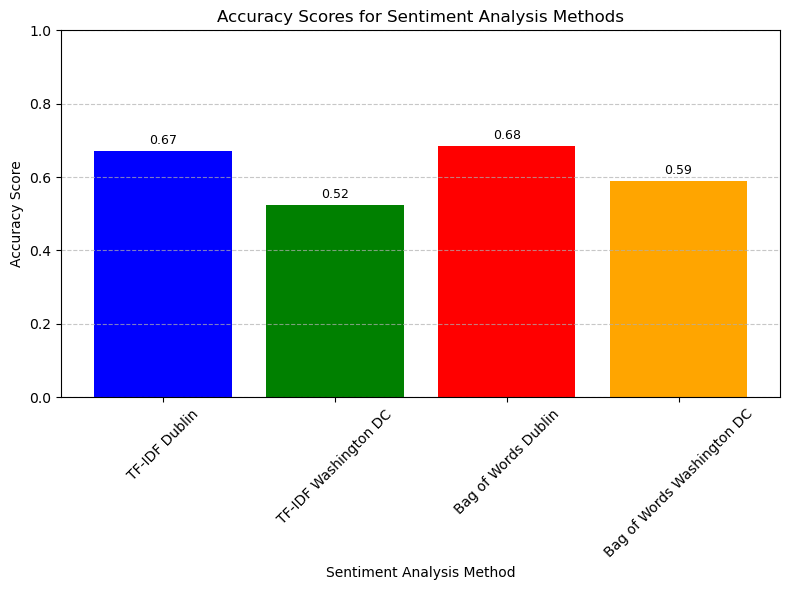

In [70]:
import matplotlib.pyplot as plt

# Initialize empty lists
labels = []
scores = []

# Append labels and scores for TF-IDF vectorization of Dublin
labels.append('TF-IDF Dublin')
scores.append(sentiment_analysis(dublin_reviews_df, 'tf_idf'))

# Append labels and scores for TF-IDF vectorization of Washington DC
labels.append('TF-IDF Washington DC')
scores.append(sentiment_analysis(capital_reviews_df, 'tf_idf'))

# Append labels and scores for Bag of Words of Dublin
labels.append('Bag of Words Dublin')
scores.append(sentiment_analysis(dublin_reviews_df, 'bow'))

# Append labels and scores for Bag of Words of Washington DC
labels.append('Bag of Words Washington DC')
scores.append(sentiment_analysis(capital_reviews_df, 'bow'))

# Print the results
print(f"Accuracy Score {labels[0]}: {scores[0]}")
print(f"Accuracy Score {labels[1]}: {scores[1]}")
print(f"Accuracy Score {labels[2]}: {scores[2]}")
print(f"Accuracy Score {labels[3]}: {scores[3]}")

# Create a bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, scores, color=['blue', 'green', 'red', 'orange'])
plt.xlabel('Sentiment Analysis Method')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores for Sentiment Analysis Methods')
plt.ylim(0, 1)  # Set the y-axis limit to [0, 1]
plt.xticks(rotation=45)  # Rotate the x-axis labels by 45 degrees
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines

# Add values on top of the bars
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{score:.2f}', 
             ha='center', va='bottom', fontsize=9)

# Show the bar chart
plt.tight_layout()
plt.show()


# Project Management
For this project, CRISP-DM (Cross-Industry Standard Process for Data Mining) framework was applied.

Also a Gantt Chart was created with the phases of the project. 

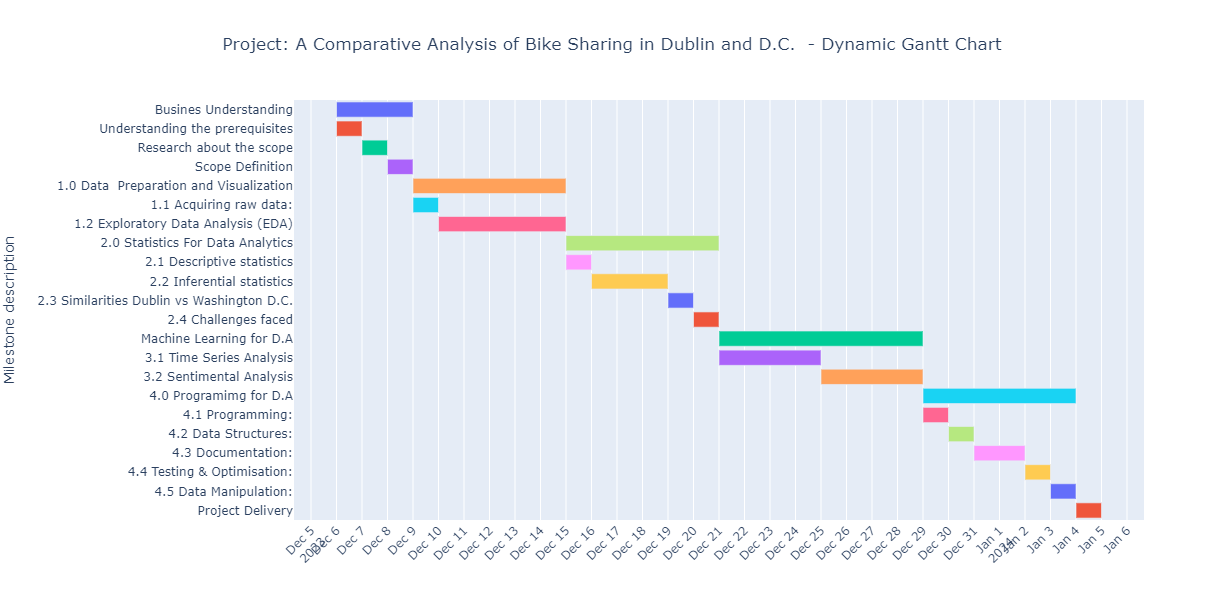

In [125]:
import pandas as pd
import plotly.express as px

# CSV file with the phases and days worked in 
df = pd.read_csv('gantt_data.csv')

df['Start'] = pd.to_datetime(df['Start'])

# Calculate the end date for each task by adding the duration to the start date
df['End'] = df['Start'] + pd.to_timedelta(df['Days'], unit='D')

# Initialize the Gantt chart using Plotly Express
fig = px.timeline(df, x_start='Start', x_end='End', y='Milestone description', color='Milestone description',
                  title='Project: A Comparative Analysis of Bike Sharing in Dublin and D.C.  - Dynamic Gantt Chart', 
                  width=1100, height=600)

# Set the x-axis tick mode and dtick to show all dates
fig.update_layout(xaxis=dict(tickmode='linear', dtick='D1'))

# Rotate the date labels on the x-axis by 45 degrees
fig.update_layout(xaxis=dict(tickangle=-45))
fig.update_layout(showlegend=False)
fig.update_layout(yaxis=dict(showticklabels=True))
fig.update_layout(title_x=0.5)


# Show the Gantt chart
fig.show()